In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import collections
import pickle
import time
from sklearn import cluster
from sklearn.metrics import adjusted_rand_score
import scipy as sp
from sklearn.manifold import MDS
from multiprocessing import Pool
from run_dist_mat import *
from chromosome_alignment import *
import itertools
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from sklearn.metrics import silhouette_score, silhouette_samples 
from scipy.spatial import distance


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [32]:
reads_to_inlcude = "inliers" #"all"
clustering_method = "pckmeans" # "igs"
num_chrs = 19
bin_size = 200e6

data = read_data(clustering_method, reads_to_inlcude) #cells with less than 150 reads are deleted: 80.,  84., 105., 113.

cum_lens = get_chr_cumulative_lengths()

cell_i_index = 25
cell_j_index = 26

cell_i = data.loc[(data.cell_index==cell_i_index) & (data.chr < 20)].copy()
cell_i['abs_pos'] = -1
cell_i['abs_pos'] = cell_i.pos.copy() + [cum_lens[ch-1] for ch in cell_i.chr] #encodes the absolute position of the reads along the linear genome
cell_j = data.loc[(data.cell_index==cell_j_index) & (data.chr < 20)].copy()
cell_j['abs_pos'] = -1
cell_j['abs_pos'] = cell_j.pos.copy() + [cum_lens[ch-1] for ch in cell_j.chr] #encodes the absolute position of the reads along the linear genome


bins, num_bins_per_chr = get_bins(bin_size, cum_lens, num_chrs)

cell_i_dist,cell_i_groups = pckmeans_get_dist_mat_binned(cell_i, bins, num_bins_per_chr, sample_from_bin = 'mean')
cell_j_dist,cell_j_groups = pckmeans_get_dist_mat_binned(cell_j, bins, num_bins_per_chr, sample_from_bin = 'mean')

order = np.arange(1,20)

# d, bit_seq, bin_seq_j ,bin_seq_i = get_aligned_inter_cell_dist(cell_i_dist, cell_j_dist, num_bins_per_chr, chr_seq = order) #np.arange(19,0,-1)
        

In [19]:
print(cell_i_groups.loc[cell_i_groups.pckmeans_cluster_hap >= 0].index.get_level_values(level = 2).unique())
print(cell_j_groups.loc[cell_j_groups.pckmeans_cluster_hap >= 0].index.get_level_values(level = 2).unique())

Float64Index([1.0, 3.0, 4.0, 5.0, 6.0, 7.0, 14.0, 16.0, 17.0, 18.0, 19.0], dtype='float64', name='chr')
Float64Index([3.0, 4.0, 5.0, 7.0, 8.0, 11.0, 14.0, 15.0, 17.0, 18.0, 19.0], dtype='float64', name='chr')


## Checking to see how well sister cells are aligned
#### Because for the chromosomes that ARE haplotyped, we want the alignments to match since they came from the same territory before division

In [24]:
# j_hap[haplotpyed_intersection]
def equal_ignoring_nans(a,b):
    return ((a == b) | (np.isnan(a) & np.isnan(b))).all()
    
def get_chromosome_misalignments(aligned_cell_i, aligned_cell_j): 
    i_hap = np.array(aligned_cell_i.pckmeans_cluster_hap)
    j_hap = np.array(aligned_cell_j.pckmeans_cluster_hap)
  
    misaligned_idx = np.where((i_hap>= 0) & (j_hap>=0) & (i_hap != j_hap) )
    misaligned_chrs = np.array(aligned_cell_i.iloc[misaligned_idx].index.get_level_values(level = 2).unique())
    
    aligned_idx = np.where((i_hap>= 0) & (j_hap>=0) & (i_hap == j_hap))
    aligned_chrs = np.array(aligned_cell_i.iloc[aligned_idx].index.get_level_values(level = 2).unique())
    
    return misaligned_chrs, aligned_chrs

In [25]:
# bin_seqs_i = []
# bin_seqs_j = []
# dists = []
# for sample in range(30):
#     order = np.arange(1,20)
#     np.random.shuffle(order)
#     d, bit_seq, bin_seq_j, bin_seq_i = get_aligned_inter_cell_dist(cell_i_dist, cell_j_dist, num_bins_per_chr, chr_seq = order) #np.arange(19,0,-1)

#     bin_seqs_i.append(bin_seq_i)
#     bin_seqs_j.append(bin_seq_j)
#     dists.append(d[0])

# min_seq_i = bin_seqs_i[np.argmin(dists)]
# min_seq_j = bin_seqs_j[np.argmin(dists)]

# aligned_cell_i = cell_i_groups.iloc[min_seq_i]
# aligned_cell_j = cell_j_groups.iloc[min_seq_j]
    
misaligned_chrs, aligned_chrs = get_chromosome_misalignments(aligned_cell_i, aligned_cell_j)
print(misaligned_chrs)
print(aligned_chrs)

[ 7. 15. 10. 17.  1.  6.  4. 18. 11. 12.  9.  8. 16.  3. 19. 13. 14.  5.
  2.]
[]


0.4477195668126833
chromosome misalignment b/w sister cells 1 and 2: []
0.4095087834935389
chromosome misalignment b/w sister cells 2 and 3: [ 2.  6. 10. 13.  5.  9. 12. 14. 16. 18.  3. 15.  7.  1.  4. 11.  8. 17.
 19.]
0.4337720536716885
chromosome misalignment b/w sister cells 3 and 4: [ 9. 16. 17. 15.  3. 19. 10.  6.  2.  8.  1. 14. 11. 18. 12.  4.  5. 13.
  7.]
0.49883955763543797
chromosome misalignment b/w sister cells 4 and 5: [ 7. 19.  2. 13.  5. 18.  3.  4.  9. 15. 16.  6. 14.  8. 10. 12.  1. 17.
 11.]
0.542586030923399
chromosome misalignment b/w sister cells 5 and 6: [ 1. 10. 15. 11. 19.  9.  2.  6. 16.  7.  8. 13.  3.  4. 12. 17. 14.  5.
 18.]
0.44883717303721204
chromosome misalignment b/w sister cells 1 and 6: []
0.434734715526228
chromosome misalignment b/w sister cells 9 and 10: [18. 19. 15.  3.  4.  1.  8. 10. 12.  2.  5. 17.  7. 16. 13. 11.  9. 14.
  6.]
0.5039761365576565
chromosome misalignment b/w sister cells 11 and 16: [14. 17.  9. 15.  5.  6.  1. 10. 12. 16. 11.

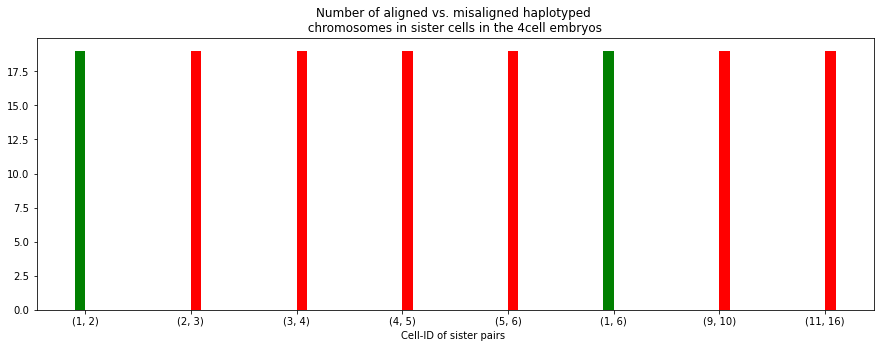

In [73]:
sister_cells_2cell = []
for emb_id in data.loc[data.stage == '2cell', 'embryo_id'].unique():
    sister_cells_2cell.append(tuple(data.loc[data.embryo_id == emb_id, 'cell_index'].unique()))

sister_pairs_4cell = [(66, 67), (65,68), (69,71), (70,72),(74,75),\
                (73,76), (77,78), (81,83), (86,87),(85,88),\
                (90,91),(92,93),(96,97), (95,98), (99,100),\
                (102,104), (106,107), (108,109), (110,111)]
zygotes = [(1,2),(2,3), (3,4), (4,5), (5,6), (1,6), (9,10), (11, 16)]

num_samples = 50
plt.figure(figsize = (15,5))
for i, sister_pair in enumerate(zygotes):
    cell_i_index = sister_pair[0]
    cell_j_index = sister_pair[1]

    cell_i = data.loc[(data.cell_index==cell_i_index) & (data.chr < 20)].copy()
    cell_i['abs_pos'] = -1
    cell_i['abs_pos'] = cell_i.pos.copy() + [cum_lens[ch-1] for ch in cell_i.chr] #encodes the absolute position of the reads along the linear genome
    cell_j = data.loc[(data.cell_index==cell_j_index) & (data.chr < 20)].copy()
    cell_j['abs_pos'] = -1
    cell_j['abs_pos'] = cell_j.pos.copy() + [cum_lens[ch-1] for ch in cell_j.chr] #encodes the absolute position of the reads along the linear genome


    bins, num_bins_per_chr = get_bins(bin_size, cum_lens, num_chrs)

    cell_i_dist,cell_i_groups = pckmeans_get_dist_mat_binned(cell_i, bins, num_bins_per_chr, sample_from_bin = 'mean')
    cell_j_dist,cell_j_groups = pckmeans_get_dist_mat_binned(cell_j, bins, num_bins_per_chr, sample_from_bin = 'mean')



    bin_seqs_i = []
    bin_seqs_j = []
    dists = []
    for sample in range(num_samples):
        order = np.arange(1,20)
        np.random.shuffle(order)
        d, bit_seq, bin_seq_j, bin_seq_i = get_aligned_inter_cell_dist(cell_i_dist, cell_j_dist, num_bins_per_chr, chr_seq = order) #np.arange(19,0,-1)
#         d, bit_seq, bin_seq_j, bin_seq_i, num_haplotyped = get_aligned_inter_cell_dist_using_haplotyped_info(cell_i_dist, cell_i_groups, cell_j_dist, cell_j_groups, num_bins_per_chr, chr_seq = order) #np.arange(19,0,-1)

        bin_seqs_i.append(bin_seq_i)
        bin_seqs_j.append(bin_seq_j)
        dists.append(d[0])

    min_seq_i = bin_seqs_i[np.argmin(dists)]
    min_seq_j = bin_seqs_j[np.argmin(dists)]

    aligned_cell_i = cell_i_groups.iloc[min_seq_i]
    aligned_cell_j = cell_j_groups.iloc[min_seq_j]
    
    print(np.min(dists))
   

    misaligned_chrs, aligned_chrs = get_chromosome_misalignments(aligned_cell_i, aligned_cell_j)
    plt.bar(i-0.05, len(aligned_chrs), color = 'green', width = 0.1 )
    plt.bar(i+0.05, len(misaligned_chrs), color = 'red', width = 0.1)
    
    print("chromosome misalignment b/w sister cells {} and {}: {}".format(cell_i_index, cell_j_index, misaligned_chrs))
plt.title("Number of aligned vs. misaligned haplotyped \n chromosomes in sister cells in the 4cell embryos ")
plt.xticks(ticks = np.arange(0, len(zygotes)), labels = [str(sisters) for sisters in zygotes])
plt.xlabel("Cell-ID of sister pairs ")
plt.show()


In [64]:
set([6,1,3,4,5]) - set([4,2])

{1, 3, 5, 6}

In [67]:
# here, we automatically align the chromosomes that have been haplotyped based on just the haplotype info, 
# and then run the algorithm on the rest of the chromosomes to find the minimum distance in a greedy way...
def get_aligned_inter_cell_dist_using_haplotyped_info(cell_i_dist, cell_i_groups, cell_j_dist, cell_j_groups, num_bins_per_chr, num_chrs= 19,  
                                chr_seq = None):
    
    total_haploid_bins = np.sum([val for key,val in num_bins_per_chr.items()][:num_chrs+1])  #total number of bins for the first num_chrschromosomes
    cum_num_bins = np.cumsum([val for key,val in num_bins_per_chr.items()]) #[0,bins_chr1, bins_chr1+chr2,...] HAPLOID number of bins
 
    
    bit_wise_seq = {}  # i: 0 --> chromosome i hasn't been switched, 1 means it has been switched
    if chr_seq is None: 
        print("default chromosome sequence")
        chr_seq = np.arange(1,20)
    
    
    # First, get the haplotyped chromosomes and automatically align them
    haplotyped_chrs_i = cell_i_groups.loc[cell_i_groups.pckmeans_cluster_hap >= 0].index.get_level_values(level = 2).unique()
    haplotyped_chrs_j = cell_j_groups.loc[cell_j_groups.pckmeans_cluster_hap >= 0].index.get_level_values(level = 2).unique()
    haplotyped_chrs_both = list(set(haplotyped_chrs_i) & set(haplotyped_chrs_j))
    
    cell_i_seq = []
    cell_j_seq = []
    
    for hap_chr in haplotyped_chrs_both:
        c = int(hap_chr)
        cell_i_seq = cell_i_seq + list(np.arange(2*cum_num_bins[c-1], 2*cum_num_bins[c-1] + 2*num_bins_per_chr[c])) #this is the default sequence where we don't touch the order of copies
        cell_i_chr_happed = cell_i_groups.loc[cell_i_groups.index.get_level_values(level = 2) == c].pckmeans_cluster_hap
        cell_j_chr_happed = cell_j_groups.loc[cell_j_groups.index.get_level_values(level = 2) == c].pckmeans_cluster_hap
        if equal_ignoring_nans(cell_i_chr_happed, cell_j_chr_happed):
            cell_j_seq = cell_j_seq + list(np.arange(2*cum_num_bins[c-1], 2*cum_num_bins[c-1] + 2*num_bins_per_chr[c])) 
            bit_wise_seq[c] = 0
        else:
            cell_j_seq = cell_j_seq + list(np.arange(2*cum_num_bins[c-1] + num_bins_per_chr[c], 2*cum_num_bins[c-1] + 2*num_bins_per_chr[c])) +\
                           list(np.arange(2*cum_num_bins[c-1] , 2*cum_num_bins[c-1] + num_bins_per_chr[c]))
            bit_wise_seq[c] = 1
        
            
    # Second, use the algorithm to align the rest of the chromosomes 
    non_haplotyped = [ch for ch in chr_seq if ch not in haplotyped_chrs_both ]
    for i in non_haplotyped:
        i = int(i)
        cell_i_seq = cell_i_seq + list(np.arange(2*cum_num_bins[i-1], 2*cum_num_bins[i-1] + 2*num_bins_per_chr[i])) #this is the default sequence where we don't touch the order of copies
        seq1 = cell_j_seq + list(np.arange(2*cum_num_bins[i-1], 2*cum_num_bins[i-1] + 2*num_bins_per_chr[i])) 
        seq2 = cell_j_seq + list(np.arange(2*cum_num_bins[i-1] + num_bins_per_chr[i], 2*cum_num_bins[i-1] + 2*num_bins_per_chr[i])) +\
                            list(np.arange(2*cum_num_bins[i-1] , 2*cum_num_bins[i-1] + num_bins_per_chr[i]))
        
        dist1, inter_size1 = get_inter_cell_dist(cell_i_dist[np.ix_(cell_i_seq, cell_i_seq)], cell_j_dist[np.ix_(seq1, seq1)])
        dist2, inter_size2 = get_inter_cell_dist(cell_i_dist[np.ix_(cell_i_seq, cell_i_seq)], cell_j_dist[np.ix_(seq2, seq2)])
        
        
        if dist1 <= dist2:
            bit_wise_seq[i] = 0
            cell_j_seq = seq1
        elif dist2 < dist1:
            bit_wise_seq[i] = 1
            cell_j_seq = seq2
        else: #dists will be nan when we only have one value in each distance matrix
            cell_j_seq = seq1
            bit_wise_seq[i] = 0
    bit_wise_seq_list = [bit_wise_seq[i] for i in np.arange(1, 20)]

    return get_inter_cell_dist(cell_i_dist[np.ix_(cell_i_seq, cell_i_seq)], cell_j_dist[np.ix_(cell_j_seq, cell_j_seq)]), bit_wise_seq_list, cell_j_seq, cell_i_seq, len(haplotyped_chrs_both) ##############EXTEA OUTPUT
    
    


 1 2
haplotyped chrs:  19

 2 3
haplotyped chrs:  19

 3 4
haplotyped chrs:  19

 4 5
haplotyped chrs:  19

 5 6
haplotyped chrs:  19

 1 6
haplotyped chrs:  19

 9 10
haplotyped chrs:  19

 11 16
haplotyped chrs:  19


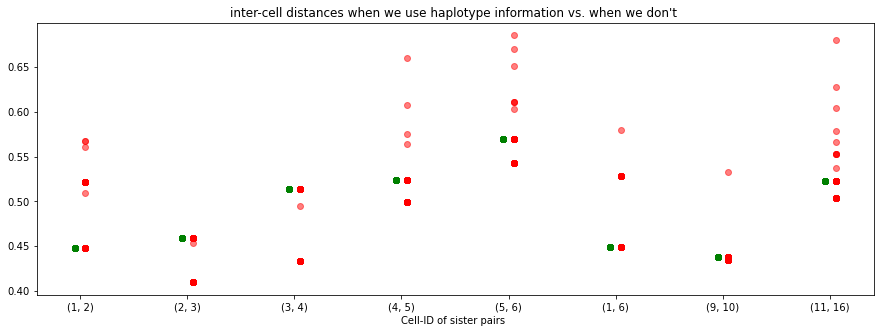

In [72]:
sister_cells_2cell = []
for emb_id in data.loc[data.stage == '2cell', 'embryo_id'].unique():
    sister_cells_2cell.append(tuple(data.loc[data.embryo_id == emb_id, 'cell_index'].unique()))

sister_pairs_4cell = [(66, 67), (65,68), (69,71), (70,72),(74,75),\
                (73,76), (77,78), (81,83), (86,87),(85,88),\
                (90,91),(92,93),(96,97), (95,98), (99,100),\
                (102,104), (106,107), (108,109), (110,111)]
zygotes = [(1,2),(2,3), (3,4), (4,5), (5,6), (1,6), (9,10), (11, 16)]

num_samples = 50
plt.figure(figsize = (15,5))
for i, sister_pair in enumerate(zygotes):
    cell_i_index = sister_pair[0]
    cell_j_index = sister_pair[1]
    print("\n", cell_i_index, cell_j_index)

    cell_i = data.loc[(data.cell_index==cell_i_index) & (data.chr < 20)].copy()
    cell_i['abs_pos'] = -1
    cell_i['abs_pos'] = cell_i.pos.copy() + [cum_lens[ch-1] for ch in cell_i.chr] #encodes the absolute position of the reads along the linear genome
    cell_j = data.loc[(data.cell_index==cell_j_index) & (data.chr < 20)].copy()
    cell_j['abs_pos'] = -1
    cell_j['abs_pos'] = cell_j.pos.copy() + [cum_lens[ch-1] for ch in cell_j.chr] #encodes the absolute position of the reads along the linear genome


    bins, num_bins_per_chr = get_bins(bin_size, cum_lens, num_chrs)

    cell_i_dist,cell_i_groups = pckmeans_get_dist_mat_binned(cell_i, bins, num_bins_per_chr, sample_from_bin = 'mean')
    cell_j_dist,cell_j_groups = pckmeans_get_dist_mat_binned(cell_j, bins, num_bins_per_chr, sample_from_bin = 'mean')



 
    dists_with_hap = []
    dists_without_hap = []
    for sample in range(num_samples):
        order = np.arange(1,20)
        np.random.shuffle(order)
        d_hap, bit_seq, bin_seq_j, bin_seq_i, num_haplotyped = get_aligned_inter_cell_dist_using_haplotyped_info(cell_i_dist, cell_i_groups, cell_j_dist, cell_j_groups, num_bins_per_chr, chr_seq = order) #np.arange(19,0,-1)
        dists_with_hap.append(d_hap[0])
        d_no_hap, bit_seq, bin_seq_j, bin_seq_i = get_aligned_inter_cell_dist(cell_i_dist, cell_j_dist, num_bins_per_chr, chr_seq = order) #np.arange(19,0,-1)
        dists_without_hap.append(d_no_hap[0])

    print("haplotyped chrs: ", num_haplotyped)
    plt.scatter(np.ones_like(dists_with_hap)*(i-0.05), dists_with_hap , color = 'green', alpha = 0.5 )
    plt.scatter(np.ones_like(dists_without_hap)*(i+0.05), dists_without_hap, color = 'red', alpha = 0.5)
    
plt.title("inter-cell distances when we use haplotype information vs. when we don't ")
plt.xticks(ticks = np.arange(0, len(zygotes)), labels = [str(sisters) for sisters in zygotes])
plt.xlabel("Cell-ID of sister pairs ")
plt.show()


In [56]:
dists_with_hap

[0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618230011,
 0.4168230618

## Visualization of different bin resolutions

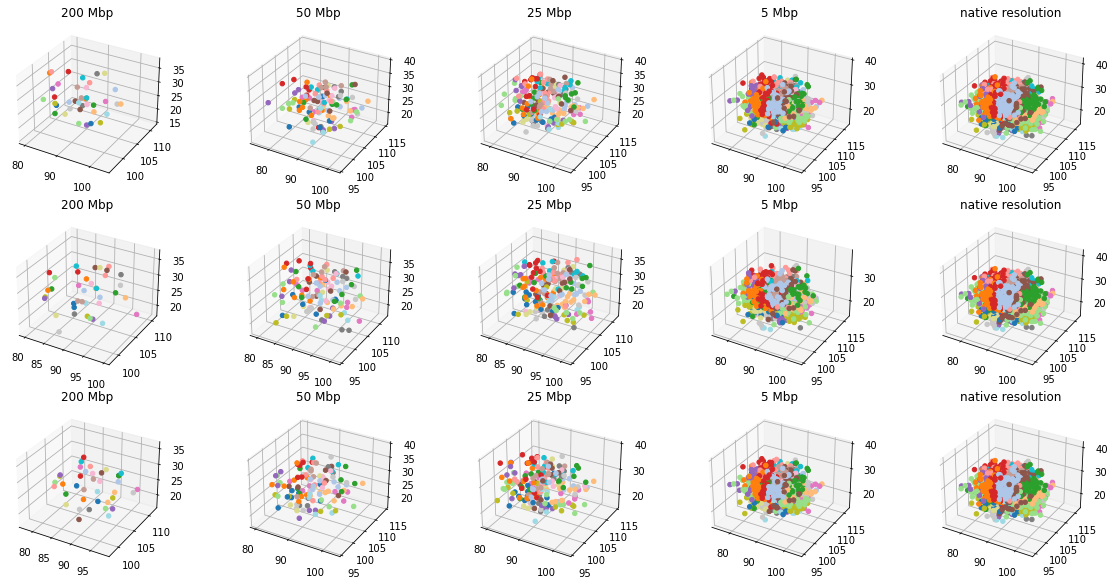

In [35]:
fig = plt.figure(figsize = (20,10))

for j in range(3):
    for i, bin_size in enumerate([200e6, 50e6, 25e6, 5e6]):
        bins, num_bins_per_chr = get_bins(bin_size, cum_lens, num_chrs)
        cell_i_dist,cell_i_groups = pckmeans_get_dist_mat_binned_resample(cell_i, bins, num_bins_per_chr, random_state = j)

        ax1 = fig.add_subplot(3,5,5*j+i+1 , projection='3d')
        ax1.scatter(cell_i_groups.x_um_abs, cell_i_groups.y_um_abs, cell_i_groups.z_um_abs, c = cell_i_groups.index.get_level_values(2), cmap = 'tab20', alpha = 1)
        ax1.set_title("{} Mbp".format(int(bin_size/1e6)))
    ax1 = fig.add_subplot(3,5,5*j+5 , projection='3d')
    ax1.scatter(cell_i.x_um_abs, cell_i.y_um_abs, cell_i.z_um_abs, c = cell_i.chr, cmap = 'tab20', alpha = 1)
    ax1.set_title("native resolution")



In [10]:
# A Dictionary that maps each bin value to the corresponding chromosome. 
# used for imputing the missing value of the chr columns introduced after the groupby operation
bin_to_chr = dict.fromkeys(bins[1:])
for bin_end in bins[1:]:
    bin_to_chr[int(bin_end)] = np.argmin(cum_lens < bin_end)
bin_to_chr

{50000000.0: 1,
 100000000.0: 1,
 150000000.0: 1,
 195471971.0: 1,
 245471971.0: 2,
 295471971.0: 2,
 345471971.0: 2,
 377585195.0: 2,
 427585195.0: 3,
 477585195.0: 3,
 527585195.0: 3,
 537624875.0: 3,
 587624875.0: 4,
 637624875.0: 4,
 687624875.0: 4,
 694132991.0: 4,
 744132991.0: 5,
 794132991.0: 5,
 844132991.0: 5,
 845967675.0: 5,
 895967675.0: 6,
 945967675.0: 6,
 995704221.0: 6,
 1045704221.0: 7,
 1095704221.0: 7,
 1141145680.0: 7,
 1191145680.0: 8,
 1241145680.0: 8,
 1270546893.0: 8,
 1320546893.0: 9,
 1370546893.0: 9,
 1395142003.0: 9,
 1445142003.0: 10,
 1495142003.0: 10,
 1525836996.0: 10,
 1575836996.0: 11,
 1625836996.0: 11,
 1647919539.0: 11,
 1697919539.0: 12,
 1747919539.0: 12,
 1768048561.0: 12,
 1818048561.0: 13,
 1868048561.0: 13,
 1888470200.0: 13,
 1938470200.0: 14,
 1988470200.0: 14,
 2013372444.0: 14,
 2063372444.0: 15,
 2113372444.0: 15,
 2117416129.0: 15,
 2167416129.0: 16,
 2215623897.0: 16,
 2265623897.0: 17,
 2310611168.0: 17,
 2360611168.0: 18,
 2401313807

Text(0.5, 1.0, '25Mbp Resolution')

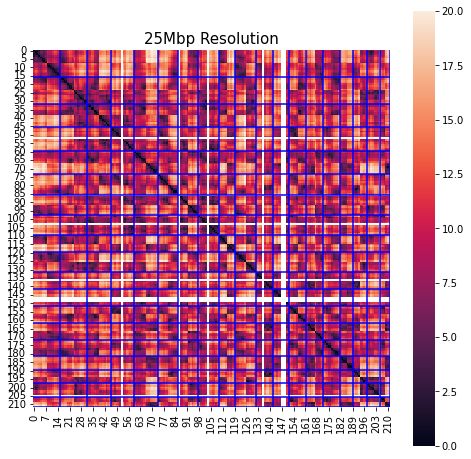

In [40]:
dd,_ = pckmeans_get_dist_mat_binned(cell_i, bins, num_bins_per_chr)
fig, ax = plt.subplots(1,1, figsize = (8,8))
sns.heatmap(dd, vmax = 20, square = True, ax = ax)
chr_bounds = [2*val for val in num_bins_per_chr.values()][1:]
plt.vlines(np.cumsum(chr_bounds),color = 'blue', *ax.get_xlim()) 
plt.hlines(np.cumsum(chr_bounds),color = 'blue', *ax.get_ylim()) 
plt.title("{}Mbp Resolution".format(int(bin_size/1e6)), fontsize = 15)

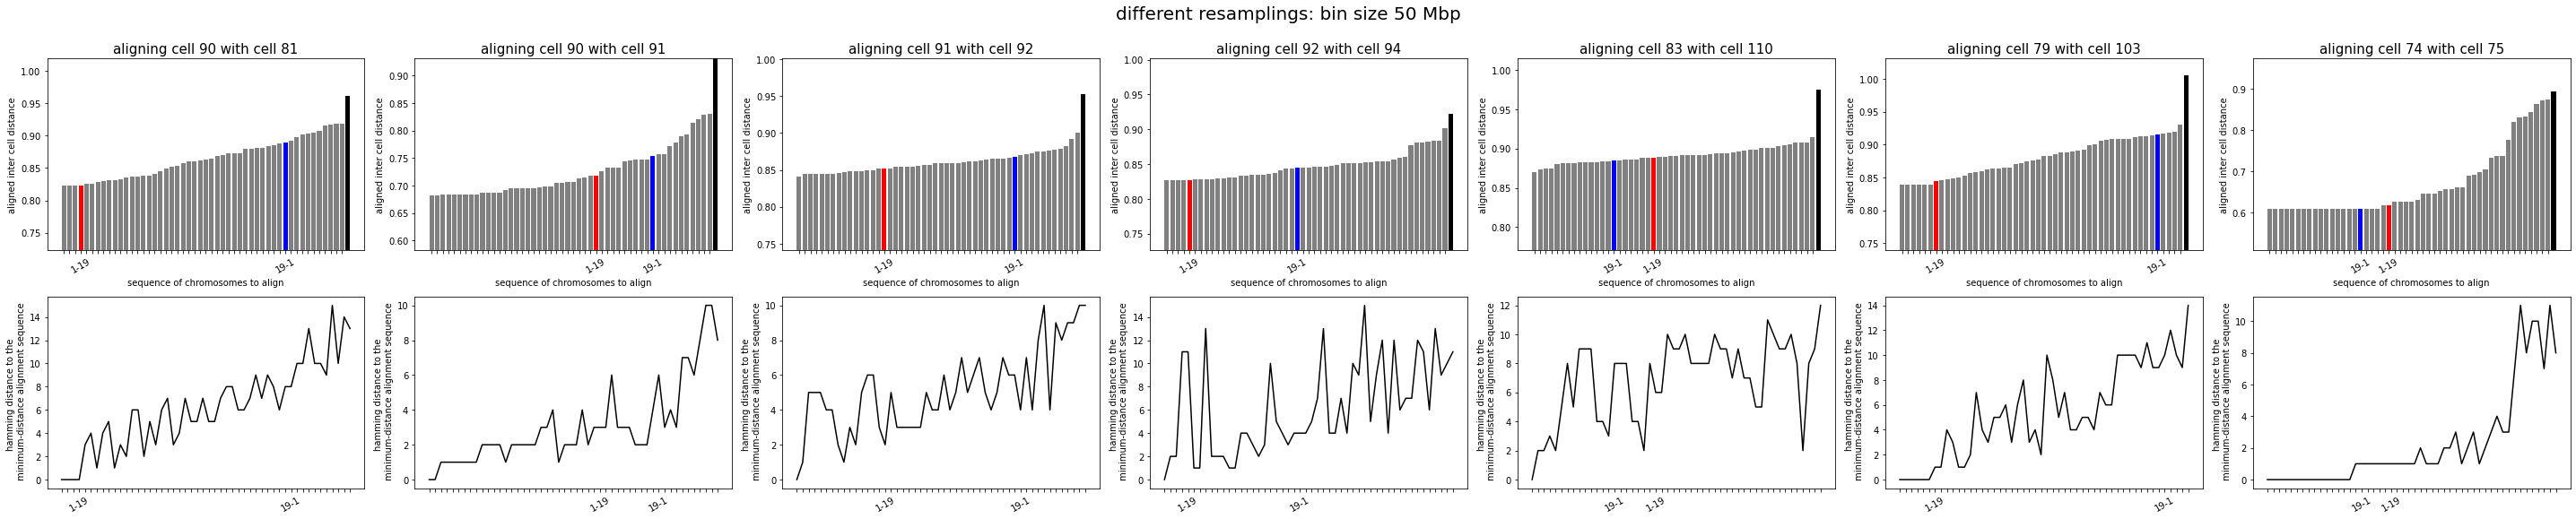

In [6]:

reads_to_inlcude = "inliers" #"all"
clustering_method = "pckmeans" # "igs"
num_chrs = 19
bin_size = 50e6

data = read_data(clustering_method, reads_to_inlcude) #cells with less than 150 reads are deleted: 80.,  84., 105., 113.

cum_lens = get_chr_cumulative_lengths()

cell_i_inds = [90, 90, 91, 92, 83, 79, 74]
cell_j_inds = [81, 91, 92, 94, 110, 103, 75]
fig, axes = plt.subplots(2,7, figsize = (40,8)) 
for i in range(len(cell_i_inds)):
    cell_i_index = cell_i_inds[i]
    cell_j_index = cell_j_inds[i]

    cell_i = data.loc[(data.cell_index==cell_i_index) & (data.chr < 20)].copy()
    cell_i['abs_pos'] = -1
    cell_i['abs_pos'] = cell_i.pos.copy() + [cum_lens[ch-1] for ch in cell_i.chr] #encodes the absolute position of the reads along the linear genome
    cell_j = data.loc[(data.cell_index==cell_j_index) & (data.chr < 20)].copy()
    cell_j['abs_pos'] = -1
    cell_j['abs_pos'] = cell_j.pos.copy() + [cum_lens[ch-1] for ch in cell_j.chr] #encodes the absolute position of the reads along the linear genome


    bins, num_bins_per_chr = get_bins(bin_size, cum_lens, num_chrs)

    cell_i_dist, _ = pckmeans_get_dist_mat_binned_resample(cell_i, bins, num_bins_per_chr)
    cell_j_dist, _ = pckmeans_get_dist_mat_binned_resample(cell_j, bins, num_bins_per_chr)
#         print("intra cell distance matrix shape: ", cell_i_dist.shape)




    seqs = []
    bin_seqs = []
    dists = []
    colors = []

    num_samples = 50
    for sample in range(num_samples):
        if sample == 0:
            order = np.arange(1,20)
            colors.append('red')
        elif sample == 1:
            order = np.arange(19,0,-1)
            colors.append('blue')
        else:
            order = np.arange(1,20)
            colors.append('grey')
            np.random.shuffle(order)
        d, bit_seq, bin_seq,_ = get_aligned_inter_cell_dist(cell_i_dist, cell_j_dist, num_bins_per_chr, chr_seq = order) #np.arange(19,0,-1)
        seqs.append(bit_seq)
        dists.append(d[0])
        bin_seqs.append(bin_seq)

    sorted_seqs = [seq for _, seq in sorted(zip(dists, seqs))]
    sorted_colors = [c for _, c in sorted(zip(dists, colors))]
    sorted_bin_seqs = [seq for _, seq in sorted(zip(dists, bin_seqs))]
    sorted_labels = np.array(["" for c in  sorted_colors], dtype = '<U4')
    sorted_labels[np.array(sorted_colors)=='red'] = "1-19"
    sorted_labels[np.array(sorted_colors)=='blue'] = "19-1"


    axes[0,i].bar(np.arange(0,num_samples), sorted(dists), color = sorted_colors)
    axes[0,i].bar(num_samples, get_inter_cell_dist(cell_i_dist, cell_j_dist)[0], color = "black")
    axes[0,i].set_xticks(np.arange(0,num_samples))
    axes[0,i].set_xticklabels(sorted_labels, rotation = 30)
    axes[0,i].set_ylim(np.min(dists)-0.1, np.max(dists)+0.1)
    axes[0,i].set_xlabel("sequence of chromosomes to align")
    axes[0,i].set_ylabel("aligned inter cell distance")
    axes[0,i].set_title("aligning cell {} with cell {}".format(cell_i_index, cell_j_index), fontsize = 15)

    hamming_dists = [distance.hamming(sorted_seqs[0], seq)*19 for seq in sorted_seqs]
    axes[1,i].plot(np.arange(0,num_samples), hamming_dists, color = 'black')
    axes[1,i].set_xticks(np.arange(0,num_samples))
    axes[1,i].set_xticklabels(sorted_labels, rotation = 30)
    axes[1,i].set_ylabel("hamming distance to the \n minimum-distance alignment sequence")

plt.suptitle("different resamplings: bin size {} Mbp".format(int(bin_size/1e6)), y = 1.0, fontsize = 20)
plt.tight_layout()
plt.savefig("figures/sequential_alignment_resample_analysis_bin_size_{}.png".format(int(bin_size/1e6)), bbox_inches='tight')
plt.show()

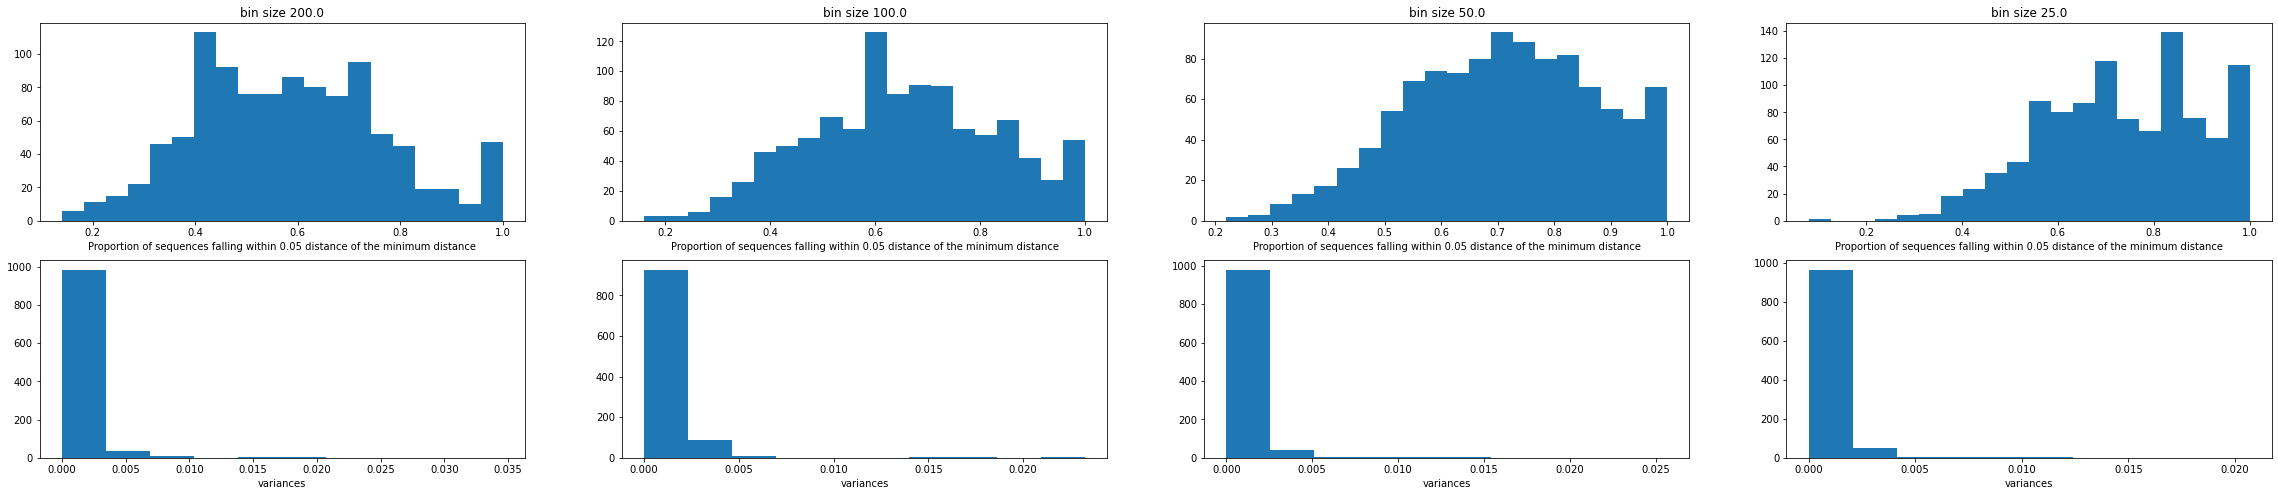

In [8]:
reads_to_inlcude = "inliers" #"all"
clustering_method = "pckmeans" # "igs"
num_chrs = 19

data = read_data(clustering_method, reads_to_inlcude) #cells with less than 150 reads are deleted: 80.,  84., 105., 113.

cum_lens = get_chr_cumulative_lengths()


fig, axes = plt.subplots(2,4, figsize = (40,8)) 
for i, bin_size in enumerate([200e6, 100e6, 50e6, 25e6]):
    proportion_matching = []
    variances = []
    for cell_i_index in data.loc[data.stage == '4cell', 'cell_index'].unique():
        cids_after_i = data.loc[data.cell_index >= cell_i_index, 'cell_index'].unique()
        for cell_j_index in cids_after_i:

            cell_i = data.loc[(data.cell_index==cell_i_index) & (data.chr < 20)].copy()
            cell_i['abs_pos'] = -1
            cell_i['abs_pos'] = cell_i.pos.copy() + [cum_lens[ch-1] for ch in cell_i.chr] #encodes the absolute position of the reads along the linear genome
            cell_j = data.loc[(data.cell_index==cell_j_index) & (data.chr < 20)].copy()
            cell_j['abs_pos'] = -1
            cell_j['abs_pos'] = cell_j.pos.copy() + [cum_lens[ch-1] for ch in cell_j.chr] #encodes the absolute position of the reads along the linear genome


            bins, num_bins_per_chr = get_bins(bin_size, cum_lens, num_chrs)

            cell_i_dist, _ = pckmeans_get_dist_mat_binned(cell_i, bins, num_bins_per_chr)
            cell_j_dist, _ = pckmeans_get_dist_mat_binned(cell_j, bins, num_bins_per_chr)
    #         print("intra cell distance matrix shape: ", cell_i_dist.shape)

            seqs = []
            bin_seqs = []
            dists = []
            colors = []

            num_samples = 50
            for sample in range(num_samples):
                if sample == 0:
                    order = np.arange(1,20)
                    colors.append('red')
                elif sample == 1:
                    order = np.arange(19,0,-1)
                    colors.append('blue')
                else:
                    order = np.arange(1,20)
                    colors.append('grey')
                    np.random.shuffle(order)
                d, bit_seq, bin_seq, _ = get_aligned_inter_cell_dist(cell_i_dist, cell_j_dist, num_bins_per_chr, chr_seq = order) #np.arange(19,0,-1)
                seqs.append(bit_seq)
                dists.append(d[0])
                bin_seqs.append(bin_seq)


            proportion_matching.append(np.mean(dists < np.min(dists) +0.05))
            variances.append(np.var(dists))


    axes[0,i].hist(proportion_matching, bins = 20)
    axes[0,i].set_title("bin size {}".format(bin_size/1e6))
    axes[0,i].set_xlabel("Proportion of sequences falling within 0.05 distance of the minimum distance")
    axes[1,i].hist(variances)
    axes[1,i].set_xlabel("variances")
plt.savefig("figures/sequential_algorithm_consistency.png")

plt.show()

minimum distance:  0.7694963481875028


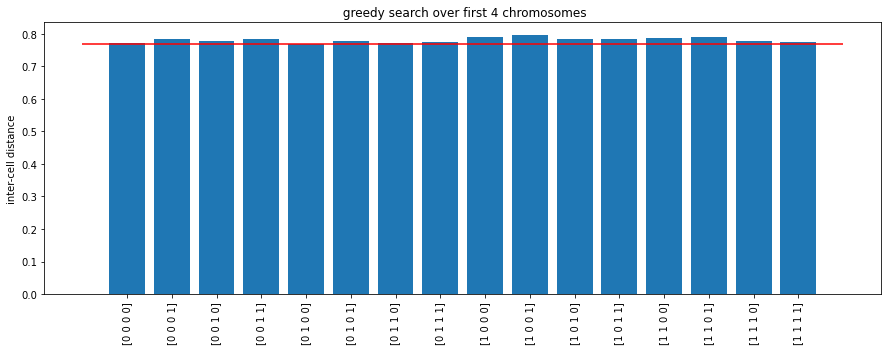

In [21]:
m = 4
run_full_search(cell_i_dist, cell_j_dist, m, num_bins_per_chr )

In [75]:
def make_dist_mat_from_rows(bin_size):
    clustering_method = "pckmeans"
    reads_to_include = "inliers"
    sample = "mean"
#     random_state = 500
    num_chrs = 19
    print("clustering method: ", clustering_method)
    print("including {} reads".format(reads_to_include))
    data = read_data(clustering_method, reads_to_include) #global variables
    data = data.loc[data.stage == "4cell"]
    
    cids_4cell = data.cell_index.unique()
    num_cells = len(cids_4cell)
    
    
    dist_mat = np.empty((num_cells,num_cells))
    dist_mat[:] = np.nan
    
    intersection_size_mat = np.empty((num_cells,num_cells))
    intersection_size_mat[:] = np.nan
    
    
    upper_triangular_ind = np.triu_indices(dist_mat.shape[0])
    dists_arr= np.array([])#a one dimensional array corresponding to the upper triangular of dist_mat
    intersections_array = np.array([])
    for cid in cids_4cell:
        x = np.load('data/temp/aligned_dist_{}_bin_size_{}_{}_numchrs_{}_cell{}.npy'.format(reads_to_include, int(bin_size/1e6), sample,\
                                                                   num_chrs, cid))
        y = np.load('data/temp/aligned_dist_{}_intersection_size_bin_size_{}_{}_numchrs_{}_cell{}.npy'.format(reads_to_include, int(bin_size/1e6), sample, \
                                                                   num_chrs, cid))


                 
        dists_arr = np.append(dists_arr, x)
        intersections_array = np.append(intersections_array,y)
    assert dists_arr.shape[0] == num_cells * (num_cells+1)/2, print(dists_arr.shape[0], num_cells)
    dist_mat[upper_triangular_ind] = dists_arr
    intersection_size_mat[upper_triangular_ind] = intersections_array
    
    np.save("data/inter_cell_aligned_dist_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp_{}.npy".format(num_chrs, clustering_method, reads_to_include, int(bin_size/1e6), sample), dist_mat)
    np.save("data/inter_cell_aligned_dist_intersection_size_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp_{}.npy".format(num_chrs, clustering_method, reads_to_include, int(bin_size/1e6), sample), intersection_size_mat)
    print("saved data")
    return 
    


In [76]:
for bin_size in [10e6, 25e6]: #, 50e6, 25e6
    dist = make_dist_mat_from_rows(bin_size = bin_size)

clustering method:  pckmeans
including inliers reads
saved data
clustering method:  pckmeans
including inliers reads
saved data


## Analyzing inter-cell distances

In [2]:
reads_to_include = "inliers" #"all"
clustering_method = "pckmeans" # "igs"
bin_size = 25 #Mbp
data = read_data(clustering_method, reads_to_include) #cells with less than 150 reads are deleted: 80.,  84., 105., 113.


cell_id_to_id = {}
id_to_cell_id = {}
cids = np.array(data.loc[data.stage == '4cell', 'cell_index'].unique())
for i,cell_id in enumerate(cids):
    cell_id_to_id[cell_id] = i
    id_to_cell_id[i] = cell_id 
    
_4cell_cids = data.loc[data.stage == '4cell', 'cell_index'].unique()

ids = np.array([cell_id_to_id[cid] for cid in cids])
eids =  np.array(data.embryo_id.unique())
ids_embryo_change = np.array([i for i in ids[1:] if data.loc[data.cell_index == id_to_cell_id[i], 'embryo_id'].unique() != data.loc[data.cell_index == id_to_cell_id[i-1], 'embryo_id'].unique()]) #ids at which we have a new embryo 
ids_embryo_change = np.append(ids_embryo_change, cell_id_to_id[cids[-1]]+1 )
ids_embryo_change = np.append([0],ids_embryo_change)


In [3]:
dist = np.load("data/inter_cell_aligned_dist_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp.npy".format(19, clustering_method, reads_to_include, bin_size))
dist[np.where(np.isnan(dist))] = 0 
dist = dist+dist.T

intersection_4cell = np.load("data/inter_cell_aligned_dist_intersection_size_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp.npy".format(19, clustering_method, reads_to_include, bin_size))
# intersection_4cell[np.where(np.isnan(intersection_4cell))] = 0 
# intersection_4cell = intersection_4cell+intersection_4cell.T
cum_lens = get_chr_cumulative_lengths()
bins, _ = get_bins(bin_size*1e6, cum_lens, num_chrs = 19)
n_to_num_bins = {}
num_bins = 2 * (len(bins) - 1)
for num_bin in range(num_bins+1):
    n_to_num_bins[num_bin * (num_bin-1)/2] = num_bin

for i in range(intersection_4cell.shape[0]):
    for j in range(i, intersection_4cell.shape[1]):
         intersection_4cell[i,j] = n_to_num_bins[intersection_4cell[i,j]]


Text(0.5, 1.0, 'inter-cell distance in 4cell embryos: 1-corr(cell_i, cell_j)')

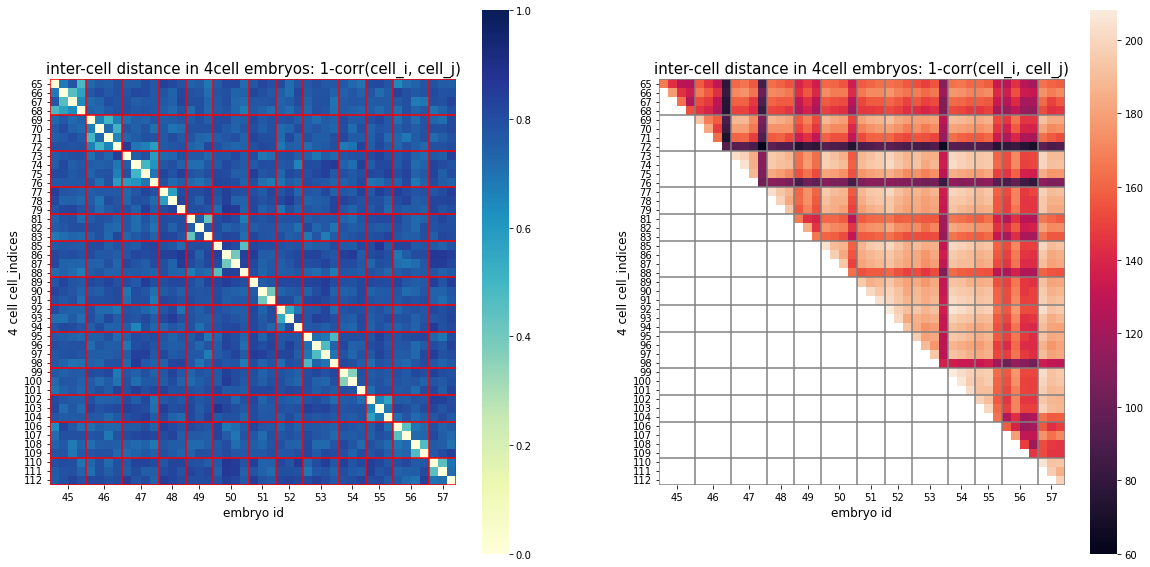

In [4]:
fig, axes = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(dist, ax = axes[0], square = True, vmax = 1, cmap = 'YlGnBu')
axes[0].vlines(ids_embryo_change,color = 'red', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[0].hlines(ids_embryo_change,color = 'red', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[0].set_xticks((ids_embryo_change[:-1] + ids_embryo_change[1:])[-13:]/2)
axes[0].set_xticklabels(eids[-13:])
axes[0].set_yticklabels([id_to_cell_id[i] for i in ids])
axes[0].set_ylabel("4 cell cell_indices", fontsize = 12)
axes[0].set_xlabel("embryo id", fontsize = 12)
axes[0].set_title("inter-cell distance in 4cell embryos: 1-corr(cell_i, cell_j)", fontsize = 15)

sns.heatmap(intersection_4cell, ax = axes[1], square = True )
axes[1].vlines(ids_embryo_change,color = 'gray', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[1].hlines(ids_embryo_change,color = 'gray', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[1].set_xticks((ids_embryo_change[:-1] + ids_embryo_change[1:])[-13:]/2)
axes[1].set_xticklabels(eids[-13:])
axes[1].set_yticklabels([id_to_cell_id[i] for i in ids])
axes[1].set_ylabel("4 cell cell_indices", fontsize = 12)
axes[1].set_xlabel("embryo id", fontsize = 12)
axes[1].set_title("inter-cell distance in 4cell embryos: 1-corr(cell_i, cell_j)", fontsize = 15)

In [5]:
ordered_ids_4cell = []
for eid in eids[-13:]:
    cids_in_embryo =  data.loc[data.embryo_id == eid, 'cell_index'].unique()
    ids_in_embryo = [cell_id_to_id[cid] for cid in cids_in_embryo]
    embryo_dist = np.triu(dist[np.ix_(ids_in_embryo,ids_in_embryo)], k = 1) #we don't include the diagonal
    embryo_dist[embryo_dist==0] = 10 #so we don't pick the zero values as min
    max_id_i, max_id_j = np.unravel_index(embryo_dist.argmin(), embryo_dist.shape)
    max_cid_i, max_cid_j = cids_in_embryo[max_id_i], cids_in_embryo[max_id_j]
    other_cids = [cid for cid in cids_in_embryo if cid not in [max_cid_i, max_cid_j]]

    ordered_ids_4cell.append(cell_id_to_id[max_cid_i])
    ordered_ids_4cell.append(cell_id_to_id[max_cid_j])
    for other_cid in other_cids:
        ordered_ids_4cell.append(cell_id_to_id[other_cid])


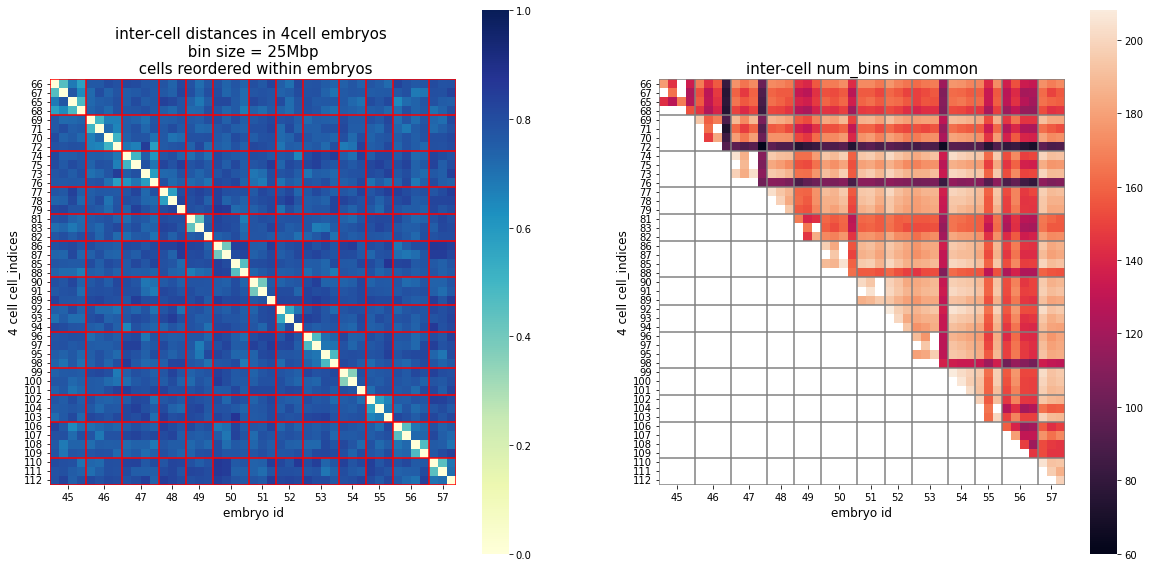

In [6]:
fig, axes = plt.subplots(1,2, figsize = (20,10))
sns.heatmap(dist[np.ix_(ordered_ids_4cell,ordered_ids_4cell)], ax = axes[0], vmax = 1, square = True, cmap = 'YlGnBu')
axes[0].vlines(ids_embryo_change,color = 'red', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[0].hlines(ids_embryo_change,color = 'red', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[0].set_xticks((ids_embryo_change[:-1] + ids_embryo_change[1:])[-13:]/2)
axes[0].set_xticklabels(eids[-13:])
axes[0].set_yticklabels([id_to_cell_id[i] for i in ordered_ids_4cell])
axes[0].set_ylabel("4 cell cell_indices", fontsize = 12)
axes[0].set_xlabel("embryo id", fontsize = 12)
axes[0].set_title("inter-cell distances in 4cell embryos \n bin size = {}Mbp \n cells reordered within embryos".format(bin_size), fontsize = 15)

sns.heatmap(intersection_4cell[np.ix_(ordered_ids_4cell,ordered_ids_4cell)], ax = axes[1], square = True )
axes[1].vlines(ids_embryo_change,color = 'gray', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[1].hlines(ids_embryo_change,color = 'gray', *axes[0].get_xlim()) #drawing vertical lines separating the stages
axes[1].set_xticks((ids_embryo_change[:-1] + ids_embryo_change[1:])[-13:]/2)
axes[1].set_xticklabels(eids[-13:])
axes[1].set_yticklabels([id_to_cell_id[i] for i in ordered_ids_4cell])
axes[1].set_ylabel("4 cell cell_indices", fontsize = 12)
axes[1].set_xlabel("embryo id", fontsize = 12)
axes[1].set_title("inter-cell num_bins in common", fontsize = 15)
plt.savefig("figures/inter_cell_dist_{}Mbp.png".format(bin_size))

In [16]:
ids_embryo_change = np.append([0],ids_embryo_change)

In [7]:
div = {45: 'p',
      46: 't',
      47: 't',
      48: 'EE',
      49: '?',
      50: 't',
      51: 'EE',
      52: 'ME',
      53: 'p-ME',
      54: 'ME or EE',
      55: 't',
      56: 'p',
      57: 'ME'}

cids_4cells = cids[-45:]
embryo_labels = []
for i,cid in enumerate(cids_4cells):
    embryo_labels.append(data.loc[data.cell_index ==cid, 'embryo_id'].unique()[0]) 
embryo_labels = np.array(embryo_labels)

embryo_labels_annot = [str(lab) + "\n" + div[lab] for lab in embryo_labels]

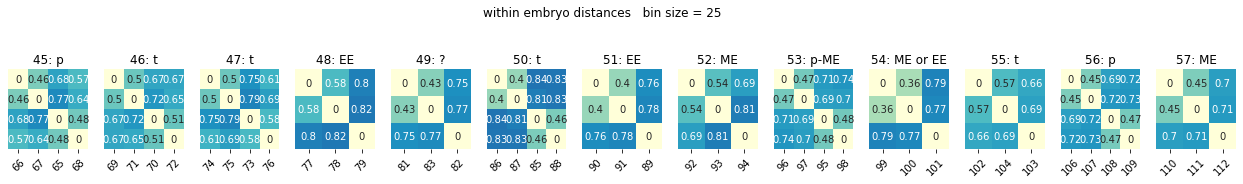

In [8]:
%matplotlib inline
fig, axes = plt.subplots(1,13, figsize = (22,3))
for counter, eid in enumerate(eids[-13:]):
    embryo_cids = data.loc[data.embryo_id == eid, 'cell_index'].unique()
    ordered_ids_embryo = [i for i in ordered_ids_4cell if id_to_cell_id[i] in embryo_cids]
    sns.heatmap(dist[np.ix_(ordered_ids_embryo,ordered_ids_embryo)], ax = axes[counter], square = True,\
                cbar = False,cmap = 'YlGnBu', vmin = 0, vmax = 1.2, yticklabels=False, annot = True)
    axes[counter].set_title(str(eid) + ": " + div[eid]) 
    axes[counter].set_xticklabels([id_to_cell_id[i] for i in ordered_ids_embryo], rotation = 45)

plt.suptitle("within embryo distances   bin size = {}".format(bin_size))
plt.savefig("figures/embryo_dists_{}.png".format(bin_size))
plt.show()

In [9]:
with open('genome_mixing_metrics_dict_snp_level.pkl', 'rb') as f:   #genome_mixing_metrics_dict
    genome_mixing_metrics = pickle.load(f)
num_snps = np.load("genome_mixing_num_snps.npy")
# method_names = ["Sum_of_Squares", "Silhouette", "Linear Classifier", "nearest neighbors", 'Bhattacharyya_dist']
method = "Bhattacharyya_dist"

In [10]:
dist = np.load("data/inter_cell_aligned_dist_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp.npy".format(19, clustering_method, reads_to_include, bin_size))
dist[np.where(np.isnan(dist))] = 0 
dist = dist+dist.T

In [ ]:
linkage_type = 'complete'


dist_4cell = dist[-45:,-45:]
idx = np.triu_indices(45, k = 1)
dist_4cell_unrav = dist_4cell[idx]

X = dist_4cell_unrav
linked = linkage(X, linkage_type)

fig, axes = plt.subplots(2,1, figsize = (17,8),gridspec_kw={'height_ratios': [1,1]})
dendrogram(linked,
            orientation='top',
            labels= embryo_labels,
           color_threshold = 0.5,
            distance_sort='ascending',
           leaf_font_size = 13,
           leaf_rotation = 0,
            show_leaf_counts=True, 
          ax = axes[0])

#changing the color of the nodes
embryos = np.sort(eids[-13:])
vals = np.arange(0,len(embryos))
embryo_color_dict = dict(zip(embryos, vals))
color_list = plt.cm.tab20(vals)
xlbls = axes[0].get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(color_list[embryo_color_dict[int(lbl.get_text()[0:2])]])
    
    
axes[1].bar(np.arange(0,45), np.array(genome_mixing_metrics[method])[leaves_list(linked)], 
            color = color_list[[embryo_color_dict[i] for i in embryo_labels[leaves_list(linked)]]])
for i in range(45):
    axes[1].text(i-0.3, np.array(genome_mixing_metrics[method])[leaves_list(linked)[i]] - 0.2,s= num_snps[leaves_list(linked)[i]] )
axes[1].set_xlim(-0.5,44.5)
axes[1].set_xticks(np.arange(0,45))
axes[1].set_xticklabels([str(lab) for lab in _4cell_cids[leaves_list(linked)]])
axes[1].spines['top'].set_visible(False)
axes[1].set_xlabel("cell index", fontsize = 15)
axes[1].set_ylabel("parental genome separation \n"+ str(method) , fontsize = 15)


plt.suptitle("4cell clusters with {} linkage, aligned copies, bin size {}, {} reads".format(linkage_type,bin_size, reads_to_include), y = 0.95, fontsize = 15)
plt.savefig("figures/hierarchical_clusters_aligned_{}_{}_bin_size_{}.png".format(clustering_method, reads_to_include, bin_size))
plt.show()


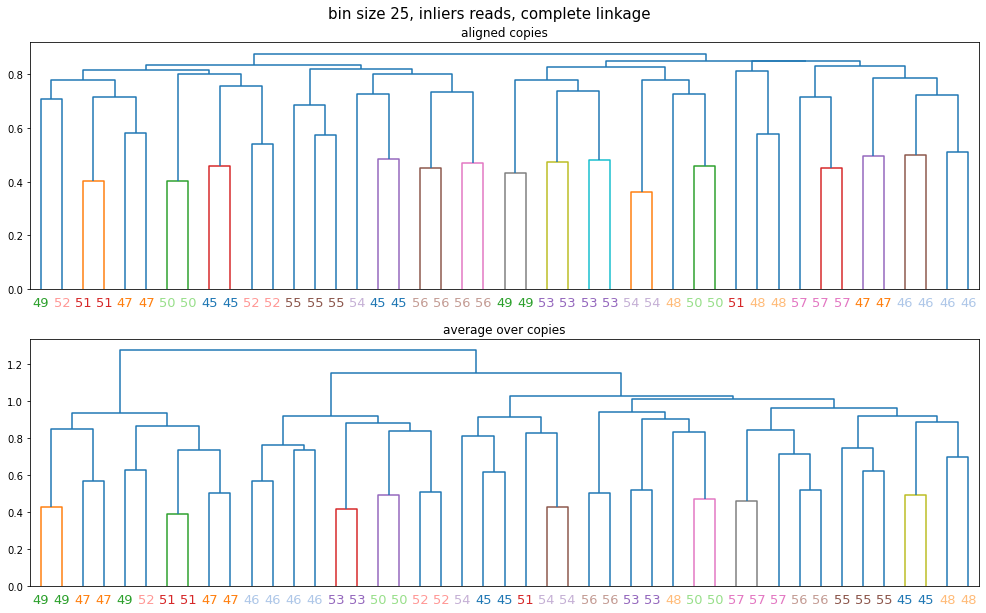

In [78]:
bin_size = 25 #Mbp
linkage_type = 'complete'
reads_to_include = "inliers"
fig, axes = plt.subplots(2,1, figsize = (17,10),gridspec_kw={'height_ratios': [1,1]})

# first, plotting the aligned copies
dist = np.load("data/inter_cell_aligned_dist_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp.npy".format(19, clustering_method, reads_to_include, bin_size))
dist[np.where(np.isnan(dist))] = 0 
dist = dist+dist.T

idx = np.triu_indices(45, k = 1)
X = dist[idx]
linked = linkage(X, linkage_type)
dendrogram(linked,
            orientation='top',
            labels= embryo_labels,
           color_threshold = 0.5,
            distance_sort='ascending',
           leaf_font_size = 13,
           leaf_rotation = 0,
            show_leaf_counts=True, 
          ax = axes[0])

#changing the color of the nodes
embryos = np.sort(eids[-13:])
vals = np.arange(0,len(embryos))
embryo_color_dict = dict(zip(embryos, vals))
color_list = plt.cm.tab20(vals)
xlbls = axes[0].get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(color_list[embryo_color_dict[int(lbl.get_text()[0:2])]])
axes[0].set_title("aligned copies")


# second, plotting the chromosome average 
method = "chr_average_binned"
inter_cell_corr = np.load("data/inter_cell_corr_{}_{}_clusters_{}_bin_size_{}Mbp.npy".format(method, clustering_method, reads_to_include, bin_size))
inter_cell_corr[np.where(np.isnan(inter_cell_corr))] = 0 
dist = 1-(inter_cell_corr+inter_cell_corr.T-np.eye(inter_cell_corr.shape[0])) # 1-->0, -1-->2
dist = dist[-45:, -45:]

idx = np.triu_indices(45, k = 1)
X = dist[idx]
linked = linkage(X, linkage_type)
dendrogram(linked,
            orientation='top',
            labels= embryo_labels,
           color_threshold = 0.5,
            distance_sort='ascending',
           leaf_font_size = 13,
           leaf_rotation = 0,
            show_leaf_counts=True, 
          ax = axes[1])

#changing the color of the nodes
embryos = np.sort(eids[-13:])
vals = np.arange(0,len(embryos))
embryo_color_dict = dict(zip(embryos, vals))
color_list = plt.cm.tab20(vals)
xlbls = axes[1].get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(color_list[embryo_color_dict[int(lbl.get_text()[0:2])]])
axes[1].set_title("average over copies")

plt.suptitle("bin size {}, {} reads, {} linkage".format(bin_size, reads_to_include, linkage_type), fontsize = 15, y = 0.93)
plt.savefig("figures/hierarchical_clusters_comparison_{}_{}_bin_size_{}_{}.png".format(clustering_method, reads_to_include, bin_size, linkage_type))
plt.show()


In [81]:
embryo_labels = []
for i,cid in enumerate(cids_4cells):
    embryo_labels.append(data.loc[data.cell_index ==cid, 'embryo_id'].unique()[0]) 
embryo_labels = np.array(embryo_labels)
daughter_cell_labels = [0,1,1,0,2,3,2,3,4,5,5,4,6,6,7,8,9,8,10,11,11,10,12,13,13,14,14,15,16,17,17,16,18,18,19,20,21,20,22,22,23,23,24,24,25]


25 0.0 0.8743504956006793
25 0.0 1.2747318803854868
50 0.0 0.8864876923984376
50 0.0 1.1288793674020337
100 0.0 0.8993036985656291
100 0.0 1.1676268194876918
200 0.0 0.9297687502640909
200 0.0 1.26911294593729


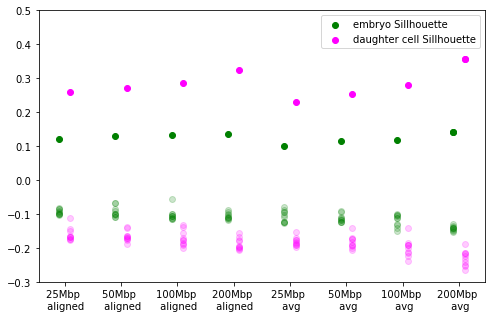

In [24]:
def get_embryo_sillhouette(dist_4cells, embryo_labels):
    return silhouette_score(dist_4cells, metric = "precomputed", labels = embryo_labels)


daughter_cell_labels_shuffled = daughter_cell_labels.copy()
embryo_labels_shuffled = embryo_labels.copy()

plt.figure(figsize = (8, 5))
for i, bin_size in enumerate([25,50,100,200]):
    dist = np.load("data/inter_cell_aligned_dist_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp.npy".format(19, clustering_method, reads_to_include, bin_size))
    dist[np.where(np.isnan(dist))] = 0 
    dist = dist+dist.T
    print(bin_size, np.min(dist), np.max(dist))
#     dist = dist/np.max(dist)
    
    
    emb_sil = get_embryo_sillhouette(dist, embryo_labels)
    daughter_sil = get_embryo_sillhouette(dist, daughter_cell_labels)


    plt.scatter(i-0.1, emb_sil, color = 'green')
    plt.scatter(i+0.1, daughter_sil, color = 'magenta')
    for _ in range(10):
        np.random.shuffle(embryo_labels_shuffled)
        np.random.shuffle(daughter_cell_labels_shuffled)
        emb_sil_shuffle = get_embryo_sillhouette(dist, embryo_labels_shuffled)
        daughter_sil_shuffle = get_embryo_sillhouette(dist, daughter_cell_labels_shuffled)
        plt.scatter(i-0.1, emb_sil_shuffle, color = 'green', alpha = 0.2)
        plt.scatter(i+0.1, daughter_sil_shuffle, color = 'magenta', alpha = 0.2)
        
    
    # second, plotting the chromosome average 
    inter_cell_corr = np.load("data/inter_cell_corr_{}_{}_clusters_{}_bin_size_{}Mbp.npy".format(method, clustering_method, reads_to_include, bin_size))
    inter_cell_corr[np.where(np.isnan(inter_cell_corr))] = 0 
    dist = 1-(inter_cell_corr+inter_cell_corr.T-np.eye(inter_cell_corr.shape[0])) # 1-->0, -1-->2
    dist = dist[-45:, -45:]
    print(bin_size, np.min(dist), np.max(dist))
    
    
    
    emb_sil = get_embryo_sillhouette(dist, embryo_labels)
    daughter_sil = get_embryo_sillhouette(dist, daughter_cell_labels)


    plt.scatter(4+i-0.1, emb_sil, color = 'green')
    plt.scatter(4+i+0.1, daughter_sil, color = 'magenta')
    for _ in range(10):
        np.random.shuffle(embryo_labels_shuffled)
        np.random.shuffle(daughter_cell_labels_shuffled)
        emb_sil_shuffle = get_embryo_sillhouette(dist, embryo_labels_shuffled)
        daughter_sil_shuffle = get_embryo_sillhouette(dist, daughter_cell_labels_shuffled)
        plt.scatter(4+i-0.1, emb_sil_shuffle, color = 'green', alpha = 0.2)
        plt.scatter(4+i+0.1, daughter_sil_shuffle, color = 'magenta', alpha = 0.2)
  
        
plt.scatter(4+i-0.1, emb_sil, color = 'green', label = "embryo Sillhouette")
plt.scatter(4+i+0.1, daughter_sil, color = 'magenta', label = "daughter cell Sillhouette")
        
plt.xticks(ticks = np.arange(0,8), labels = ['25Mbp \n aligned', '50Mbp \n aligned', '100Mbp \n aligned', '200Mbp \n aligned', '25Mbp \n avg', '50Mbp \n avg', '100Mbp \n avg', '200Mbp \n avg'])
plt.legend()
plt.ylim(-0.3, 0.5)
plt.show()


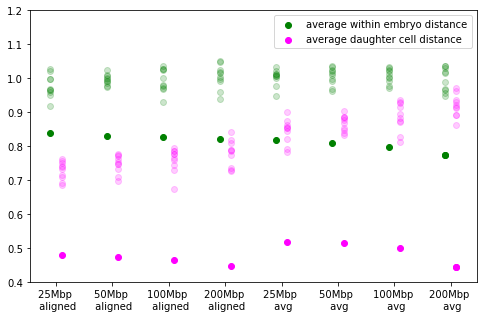

In [25]:
#i need a metric for how closely the cells in an embryo are clustered
#so first, in each embryo, i need to sum the intra-embryo distances, then i can divide that by the inter embryo distances
def get_embryo_similarity(dist):
    sim_list = []
    for embryo in range(45, 58):
        cell_indeces = data.loc[data.embryo_id==embryo,'cell_index'].unique()
        indeces = [cell_id_to_id[cell_id] for cell_id in cell_indeces]
        n = len(indeces)
        ut_ind = np.triu_indices(n, k=1)
        intra_embryo_dist = np.mean(dist[np.ix_(indeces,indeces)][ut_ind])
        inter_embryo_dist = (np.sum(dist[indeces]) - np.sum(dist[np.ix_(indeces,indeces)])) / (n * (dist.shape[0] - n))
        sim_list.append(intra_embryo_dist/inter_embryo_dist)
    return sim_list #the larger this sumber is, the better the embryos are clustered

def get_daughter_similarity(dist, daughter_cell_labels):
    #iterating through only the cells that have a sibling in the embryo. Daughter cells are identified manually and are shared by all different bin resolutions
    paired_daughter_cell_labels = [x for i, x in enumerate(daughter_cell_labels) if i != daughter_cell_labels.index(x)]
    
    sim_list = []
    for daughter_label in paired_daughter_cell_labels:
        daughter_ind = np.array(daughter_cell_labels) == daughter_label
        assert np.sum(daughter_ind)==2
        daughter_dist = dist[np.ix_(daughter_ind, daughter_ind)]
        sim_list.append(daughter_dist[0,1])
    return sim_list
    
plt.figure(figsize = (8, 5))
for i, bin_size in enumerate([25,50,100,200]):
    dist = np.load("data/inter_cell_aligned_dist_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp.npy".format(19, clustering_method, reads_to_include, bin_size))
    dist[np.where(np.isnan(dist))] = 0 
    dist = dist+dist.T
    
    emb_sim = np.mean(get_embryo_similarity(dist))
    daughter_sim = np.mean(get_daughter_similarity(dist, daughter_cell_labels))
    
#     plt.scatter(np.arange(45, 58), get_embryo_similarity(dist), label = bin_size)
    plt.scatter(i-0.1, emb_sim, color = 'green')
    plt.scatter(i+0.1, daughter_sim, color = 'magenta')
    for _ in range(10):
        dist_shuffled = dist.copy()
        np.random.shuffle(dist_shuffled)
      
        emb_sim_shuffled = np.mean(get_embryo_similarity(dist_shuffled.reshape(45,45)))
        daughter_sim_shuffled = np.mean(get_daughter_similarity(dist_shuffled.reshape(45,45), daughter_cell_labels))
        
        plt.scatter(i-0.1, emb_sim_shuffled, color = 'green', alpha = 0.2)
        plt.scatter(i+0.1, daughter_sim_shuffled, color = 'magenta', alpha = 0.2)
        
    
    # second, plotting the chromosome average 
    inter_cell_corr = np.load("data/inter_cell_corr_{}_{}_clusters_{}_bin_size_{}Mbp.npy".format(method, clustering_method, reads_to_include, bin_size))
    inter_cell_corr[np.where(np.isnan(inter_cell_corr))] = 0 
    dist = 1-(inter_cell_corr+inter_cell_corr.T-np.eye(inter_cell_corr.shape[0])) # 1-->0, -1-->2
    dist = dist[-45:, -45:]
#     plt.scatter(np.arange(45, 58), get_embryo_similarity(dist), label = str(bin_size) + "avg")
    
    emb_sim = np.mean(get_embryo_similarity(dist))
    daughter_sim = np.mean(get_daughter_similarity(dist, daughter_cell_labels))

    plt.scatter(4+i-0.1, emb_sim, color = 'green')
    plt.scatter(4+i+0.1, daughter_sim, color = 'magenta')
    for _ in range(10):
        dist_shuffled = dist.copy().flatten()
        np.random.shuffle(dist_shuffled)
      
        emb_sim_shuffled = np.mean(get_embryo_similarity(dist_shuffled.reshape(45,45)))
        daughter_sim_shuffled = np.mean(get_daughter_similarity(dist_shuffled.reshape(45,45), daughter_cell_labels))
        
        plt.scatter(4+i-0.1, emb_sim_shuffled, color = 'green', alpha = 0.2)
        plt.scatter(4+i+0.1, daughter_sim_shuffled, color = 'magenta', alpha = 0.2)
       
        
plt.scatter(4+i-0.1, emb_sim, color = 'green', label = "average within embryo distance")
plt.scatter(4+i+0.1, daughter_sim, color = 'magenta', label = "average daughter cell distance")
        
plt.ylim(0.4,1.2)
plt.xticks(ticks = np.arange(0,8), labels = ['25Mbp \n aligned', '50Mbp \n aligned', '100Mbp \n aligned', '200Mbp \n aligned', '25Mbp \n avg', '50Mbp \n avg', '100Mbp \n avg', '200Mbp \n avg'])
plt.legend()
plt.show()


                
        

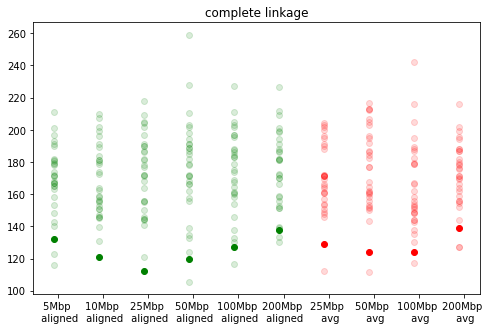

In [82]:
from scipy.stats import rankdata

#first, check that the daughter cells have the lowest distances. Then for measuring embryo similarity, look at how the 
# clusters of daughter cells are ranked based on avg/single/complete linkage, much like what hierarchical clustering does
# first, i want to put the distance matrix in a block format based on the daughter cells:
# each pair of sister cells become a block
def create_blocked_dist_mat(dist, linkage_type, daughter_cell_labels):
    num_blocks = len(np.unique(daughter_cell_labels))
    blocked_dist = np.zeros((num_blocks, num_blocks))
    
    for i, daughter_cell_label_i in enumerate(np.unique(daughter_cell_labels)):
        for j, daughter_cell_label_j in enumerate(np.unique(daughter_cell_labels)):
            inds_i = daughter_cell_labels == daughter_cell_label_i
            inds_j = daughter_cell_labels == daughter_cell_label_j
            
            daughter_block = dist[np.ix_(inds_i, inds_j)]
            if linkage_type == 'single':
                blocked_dist[i,j] = np.min(daughter_block)
            elif linkage_type == 'complete':
                blocked_dist[i,j] = np.max(daughter_block)
            elif linkage_type == 'average':
                blocked_dist[i,j] = np.mean(daughter_block)
            else:
                raise ValueError
    return blocked_dist

#we want the rank of the 1st off-diagonal values
#the lower the value, the better
def rank_based_embryo_similarity(blocked_dist):
    ranked_values = np.zeros_like(blocked_dist)
    for i, row in enumerate(blocked_dist):
        ranked_values[i,:] = rankdata(row)
    
    cousin_inds = [] #contains the indeces of the inter-sister values : [(0,1), (2,3), ...]
    for i in range(0, len(blocked_dist), 2):
        cousin_inds.append((i, i+1))
        
    total_rank = 0
    for ind in cousin_inds:
        total_rank += ranked_values[ind]
        
    return total_rank
    
    
    
linkage_type = "complete"
    
plt.figure(figsize = (8, 5))
for i, bin_size in enumerate([5, 10, 25,50,100,200]):
    dist = np.load("data/inter_cell_aligned_dist_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp.npy".format(19, clustering_method, reads_to_include, bin_size))
    dist[np.where(np.isnan(dist))] = 0 
    dist = dist+dist.T
    
    blocked_dist = create_blocked_dist_mat(dist, linkage_type, daughter_cell_labels)
    emb_sim = rank_based_embryo_similarity(blocked_dist)
    
    plt.scatter(i-0.1, emb_sim, color = 'green')
    for _ in range(30):
        dist_shuffled = dist.copy()
        np.random.shuffle(dist_shuffled)
        
        blocked_dist_shuffled = create_blocked_dist_mat(dist_shuffled.reshape(45,45), linkage_type, daughter_cell_labels)
        emb_sim_shuffled = rank_based_embryo_similarity(blocked_dist_shuffled)
        
        plt.scatter(i-0.1, emb_sim_shuffled, color = 'green', alpha = 0.15)

method = "chr_average_binned"
for i, bin_size in enumerate([25,50,100,200]):
    # second, plotting the chromosome average 
    inter_cell_corr = np.load("data/inter_cell_corr_{}_{}_clusters_{}_bin_size_{}Mbp.npy".format(method, clustering_method, reads_to_include, bin_size))
    inter_cell_corr[np.where(np.isnan(inter_cell_corr))] = 0 
    dist = 1-(inter_cell_corr+inter_cell_corr.T-np.eye(inter_cell_corr.shape[0])) # 1-->0, -1-->2
    dist = dist[-45:, -45:]
    blocked_dist = create_blocked_dist_mat(dist, linkage_type, daughter_cell_labels)
    emb_sim = rank_based_embryo_similarity(blocked_dist)
    
    plt.scatter(6+i-0.1, emb_sim, color = 'red')
    for _ in range(30):
        dist_shuffled = dist.copy()
        np.random.shuffle(dist_shuffled)
        
        blocked_dist_shuffled = create_blocked_dist_mat(dist_shuffled.reshape(45,45), linkage_type, daughter_cell_labels)
        emb_sim_shuffled = rank_based_embryo_similarity(blocked_dist_shuffled)
        
        plt.scatter(6+i-0.1, emb_sim_shuffled, color = 'red', alpha = 0.15)
          
                
plt.xticks(ticks = np.arange(0,10), labels = ['5Mbp \n aligned', '10Mbp \n aligned', '25Mbp \n aligned', '50Mbp \n aligned', '100Mbp \n aligned', '200Mbp \n aligned', '25Mbp \n avg', '50Mbp \n avg', '100Mbp \n avg', '200Mbp \n avg'])
# plt.legend()
plt.title("{} linkage".format(linkage_type))
plt.savefig("figures/ranked_based_comparison_of_bins_with_{}_linkage.png".format(linkage_type))
plt.show()



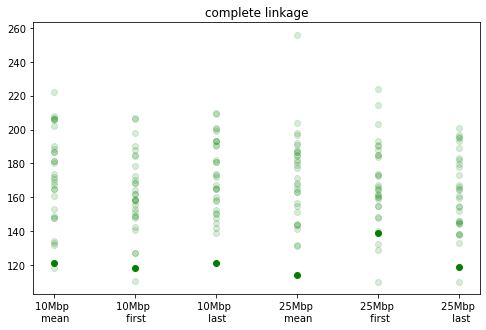

In [87]:
linkage_type = "complete"
    
plt.figure(figsize = (8, 5))
for i, bin_size in enumerate([10, 25]):
    for j, sample in enumerate(["mean", 'first', 'last']):
        dist = np.load("data/inter_cell_aligned_dist_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp_{}.npy".format(19, clustering_method, reads_to_include, bin_size, sample))
        dist[np.where(np.isnan(dist))] = 0 
        dist = dist+dist.T

        blocked_dist = create_blocked_dist_mat(dist, linkage_type, daughter_cell_labels)
        emb_sim = rank_based_embryo_similarity(blocked_dist)

        plt.scatter(j+3*i, emb_sim, color = 'green')
        for _ in range(30):
            dist_shuffled = dist.copy()
            np.random.shuffle(dist_shuffled)

            blocked_dist_shuffled = create_blocked_dist_mat(dist_shuffled.reshape(45,45), linkage_type, daughter_cell_labels)
            emb_sim_shuffled = rank_based_embryo_similarity(blocked_dist_shuffled)

            plt.scatter(j+3*i, emb_sim_shuffled, color = 'green', alpha = 0.15)

                
plt.xticks(ticks = np.arange(0,6), labels = ['10Mbp \n mean', '10Mbp \n first', '10Mbp \n last', '25Mbp \n mean', '25Mbp \n first', '25Mbp \n last'])
# plt.legend()
plt.title("{} linkage".format(linkage_type))
# plt.savefig("figures/ranked_based_comparison_of_bins_with_{}_linkage.png".format(linkage_type))
plt.show()



## Resampling Analysis

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:44<00:00, 34.96s/it]


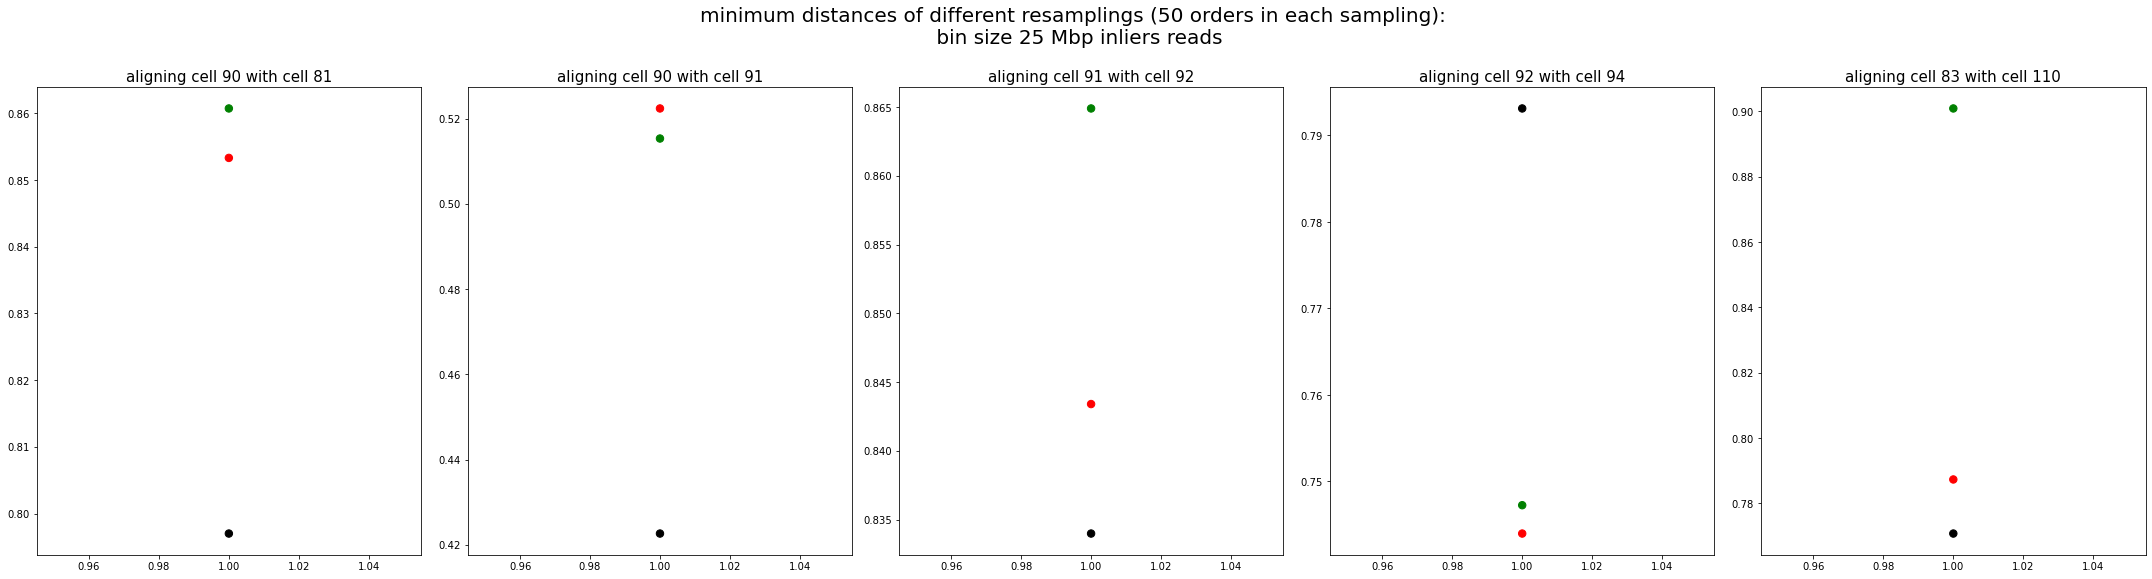

In [9]:
reads_to_include = "inliers" #"all"
clustering_method = "pckmeans" # "igs"
num_chrs = 19
bin_size = 25e6

data = read_data(clustering_method, reads_to_include) #cells with less than 150 reads are deleted: 80.,  84., 105., 113.

cum_lens = get_chr_cumulative_lengths()

cell_i_inds = [90, 90, 91, 92, 83]#, 79, 74, 99, 99, 81]
cell_j_inds = [81, 91, 92, 94, 110]#, 103, 75, 100, 101,83]
fig, axes = plt.subplots(1,5, figsize = (30,8)) 
for i in range(len(cell_i_inds)):
    cell_i_index = cell_i_inds[i]
    cell_j_index = cell_j_inds[i]

    cell_i = data.loc[(data.cell_index==cell_i_index) & (data.chr < 20)].copy()
    cell_i['abs_pos'] = -1
    cell_i['abs_pos'] = cell_i.pos.copy() + [cum_lens[ch-1] for ch in cell_i.chr] #encodes the absolute position of the reads along the linear genome
    cell_j = data.loc[(data.cell_index==cell_j_index) & (data.chr < 20)].copy()
    cell_j['abs_pos'] = -1
    cell_j['abs_pos'] = cell_j.pos.copy() + [cum_lens[ch-1] for ch in cell_j.chr] #encodes the absolute position of the reads along the linear genome


    bins, num_bins_per_chr = get_bins(bin_size, cum_lens, num_chrs)
    dists = []
    colors = []
    for sample in tqdm(['mean', 'first', 'last']):
        cell_i_dist, _ = pckmeans_get_dist_mat_binned(cell_i, bins, num_bins_per_chr, sample_from_bin = sample)
        cell_j_dist, _ = pckmeans_get_dist_mat_binned(cell_j, bins, num_bins_per_chr, sample_from_bin = sample)
 

        num_samples = 50
        for sample in range(num_samples):
            order = np.arange(1,20)
            np.random.shuffle(order)
            d, bit_seq, bin_seq,_ = get_aligned_inter_cell_dist(cell_i_dist, cell_j_dist, num_bins_per_chr, chr_seq = order) #np.arange(19,0,-1)
        dists.append(d[0])
        colors.append('black')
        
  
    axes[i%5].scatter(np.ones_like(dists), dists, color = ['black', 'red', 'green'], s = 55)
#     axes[i//5, i%5].boxplot(dists)
    axes[i%5].set_title("aligning cell {} with cell {}".format(cell_i_index, cell_j_index), fontsize = 15)
    
plt.suptitle("minimum distances of different resamplings (50 orders in each sampling): \n bin size {} Mbp {} reads".format(int(bin_size/1e6), reads_to_include), y = 1.0, fontsize = 20)
plt.tight_layout()
# plt.savefig("figures/sequential_alignment_resample_analysis_bin_size_{}_{}.png".format(int(bin_size/1e6), reads_to_include), bbox_inches='tight')
plt.show()

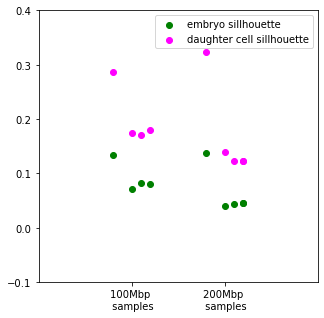

In [33]:
reads_to_include = "inliers"

plt.figure(figsize = (5, 5))
for i, bin_size in enumerate([100, 200]):
    dist = np.load("data/inter_cell_aligned_dist_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp.npy".format(19, clustering_method, reads_to_include, bin_size))
    dist[np.where(np.isnan(dist))] = 0 
    dist = dist+dist.T

#         emb_sim = np.mean(get_embryo_similarity(dist))
#         daughter_sim = np.mean(get_daughter_similarity(dist, daughter_cell_labels))
        
    emb_sil = get_embryo_sillhouette(dist, embryo_labels)
    daughter_sil = get_embryo_sillhouette(dist, daughter_cell_labels)



    plt.scatter(i-0.2, emb_sil, color = 'green')
    plt.scatter(i-0.2, daughter_sil, color = 'magenta')
          
    for j, random_seed in enumerate([0,100,10000]):
        dist = np.load("data/inter_cell_aligned_dist_resample_{}_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp.npy".format(random_seed, 19, clustering_method, reads_to_include, bin_size))
        dist[np.where(np.isnan(dist))] = 0 
        dist = dist+dist.T

#         emb_sim = np.mean(get_embryo_similarity(dist))
#         daughter_sim = np.mean(get_daughter_similarity(dist, daughter_cell_labels))
        
        emb_sil = get_embryo_sillhouette(dist, embryo_labels)
        daughter_sil = get_embryo_sillhouette(dist, daughter_cell_labels)
        

        plt.scatter(i+j/10, emb_sil, color = 'green')
        plt.scatter(i+j/10, daughter_sil, color = 'magenta')
          
plt.scatter(i+j/10, emb_sil, color = 'green', label = "embryo sillhouette")
plt.scatter(i+j/10, daughter_sil, color = 'magenta', label = "daughter cell sillhouette")
        
plt.ylim(-0.1,0.4)
plt.xlim(-1, 2)
plt.xticks(ticks = np.arange(0,2), labels = ['100Mbp \n samples',  '200Mbp \n samples'])
plt.legend()
plt.show()



## Zygote experiment
### Are the maternal and paternal packed together when i run the algorithm on zygotes?

In [2]:
reads_to_inlcude = "all" #"all"
clustering_method = "pckmeans" # "igs"
num_chrs = 19
bin_size = 100e6

data = read_data(clustering_method, reads_to_inlcude) #cells with less than 150 reads are deleted: 80.,  84., 105., 113.

cum_lens = get_chr_cumulative_lengths()


zygote_ids = data.loc[data.stage == "zygote", 'cell_index'].unique()
matches = np.zeros((len(zygote_ids),len(zygote_ids)))

for i in tqdm(range(len(zygote_ids))):
    for j in range(i, len(zygote_ids)):
        cell_i_index = zygote_ids[i]
        cell_j_index = zygote_ids[j]

        cell_i = data.loc[(data.cell_index==cell_i_index) & (data.chr < 20)].copy()
        cell_i['abs_pos'] = -1
        cell_i['abs_pos'] = cell_i.pos.copy() + [cum_lens[ch-1] for ch in cell_i.chr] #encodes the absolute position of the reads along the linear genome
        cell_j = data.loc[(data.cell_index==cell_j_index) & (data.chr < 20)].copy()
        cell_j['abs_pos'] = -1
        cell_j['abs_pos'] = cell_j.pos.copy() + [cum_lens[ch-1] for ch in cell_j.chr] #encodes the absolute position of the reads along the linear genome


        bins, num_bins_per_chr = get_bins(bin_size, cum_lens, num_chrs)

        cell_i_dist, groups_i = pckmeans_get_dist_mat_binned(cell_i, bins, num_bins_per_chr)
        cell_j_dist, groups_j = pckmeans_get_dist_mat_binned(cell_j, bins, num_bins_per_chr)




        seqs = []
        bin_seqs_i = []
        bin_seqs_j = []
        dists = []

        num_samples = 50
        for sample in range(num_samples):
            order = np.arange(1,20)
            np.random.shuffle(order)
            d, bit_seq, bin_seq_j, bin_seq_i = get_aligned_inter_cell_dist(cell_i_dist, cell_j_dist, num_bins_per_chr, chr_seq = order) #np.arange(19,0,-1)


            bin_seqs_i.append(bin_seq_i)
            bin_seqs_j.append(bin_seq_j)
            dists.append(d[0])

        min_seq_i = bin_seqs_i[np.argmin(dists)]
        min_seq_j = bin_seqs_j[np.argmin(dists)]

        # display(groups_i.iloc[min_seq_i])
        # display(groups_j.iloc[min_seq_j])
        i_hap = np.array(groups_i.iloc[min_seq_i].pckmeans_cluster_hap)
        j_hap = np.array(groups_j.iloc[min_seq_j].pckmeans_cluster_hap)
        mask = ~(np.isnan(i_hap) | np.isnan(j_hap))
        try:
            assert np.all(np.logical_xor(i_hap[mask], j_hap[mask])) or np.all(i_hap[mask] == j_hap[mask])
            print(i_hap[mask], j_hap[mask])
        except:
            print("cells {} and {} did not match".format(cell_i_index, cell_j_index))
  


  0%|                                                                                                                     | 0/24 [00:00<?, ?it/s]

[0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.] [0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]
[1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0.] [1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0.]
[1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 

  0%|                                                                                                                     | 0/24 [00:47<?, ?it/s]


KeyboardInterrupt: 

In [13]:
def get_dist(xi, xj):
    return np.linalg.norm(xi - xj)

def stress(D, embedding):
    stress = 0
    n = embedding.shape[0]
    normalization = 0
    for i in range(n):
        for j in range(i+1, n):
            stress += (get_dist(embedding[i],embedding[j]) - D[i,j])**2
            normalization += D[i,j]**2
    return np.round(np.sqrt(stress/normalization), 3)


silhouette before MDS:  0.13708327825347238
silhouette before MDS:  0.1343965419416718
silhouette before MDS:  0.13060765926885293
silhouette before MDS:  0.12210777493692783
silhouette before MDS:  0.13156854983962002
silhouette before MDS:  0.11830603124484927
silhouette before MDS:  0.11603674940123607
silhouette before MDS:  0.10679723379029712


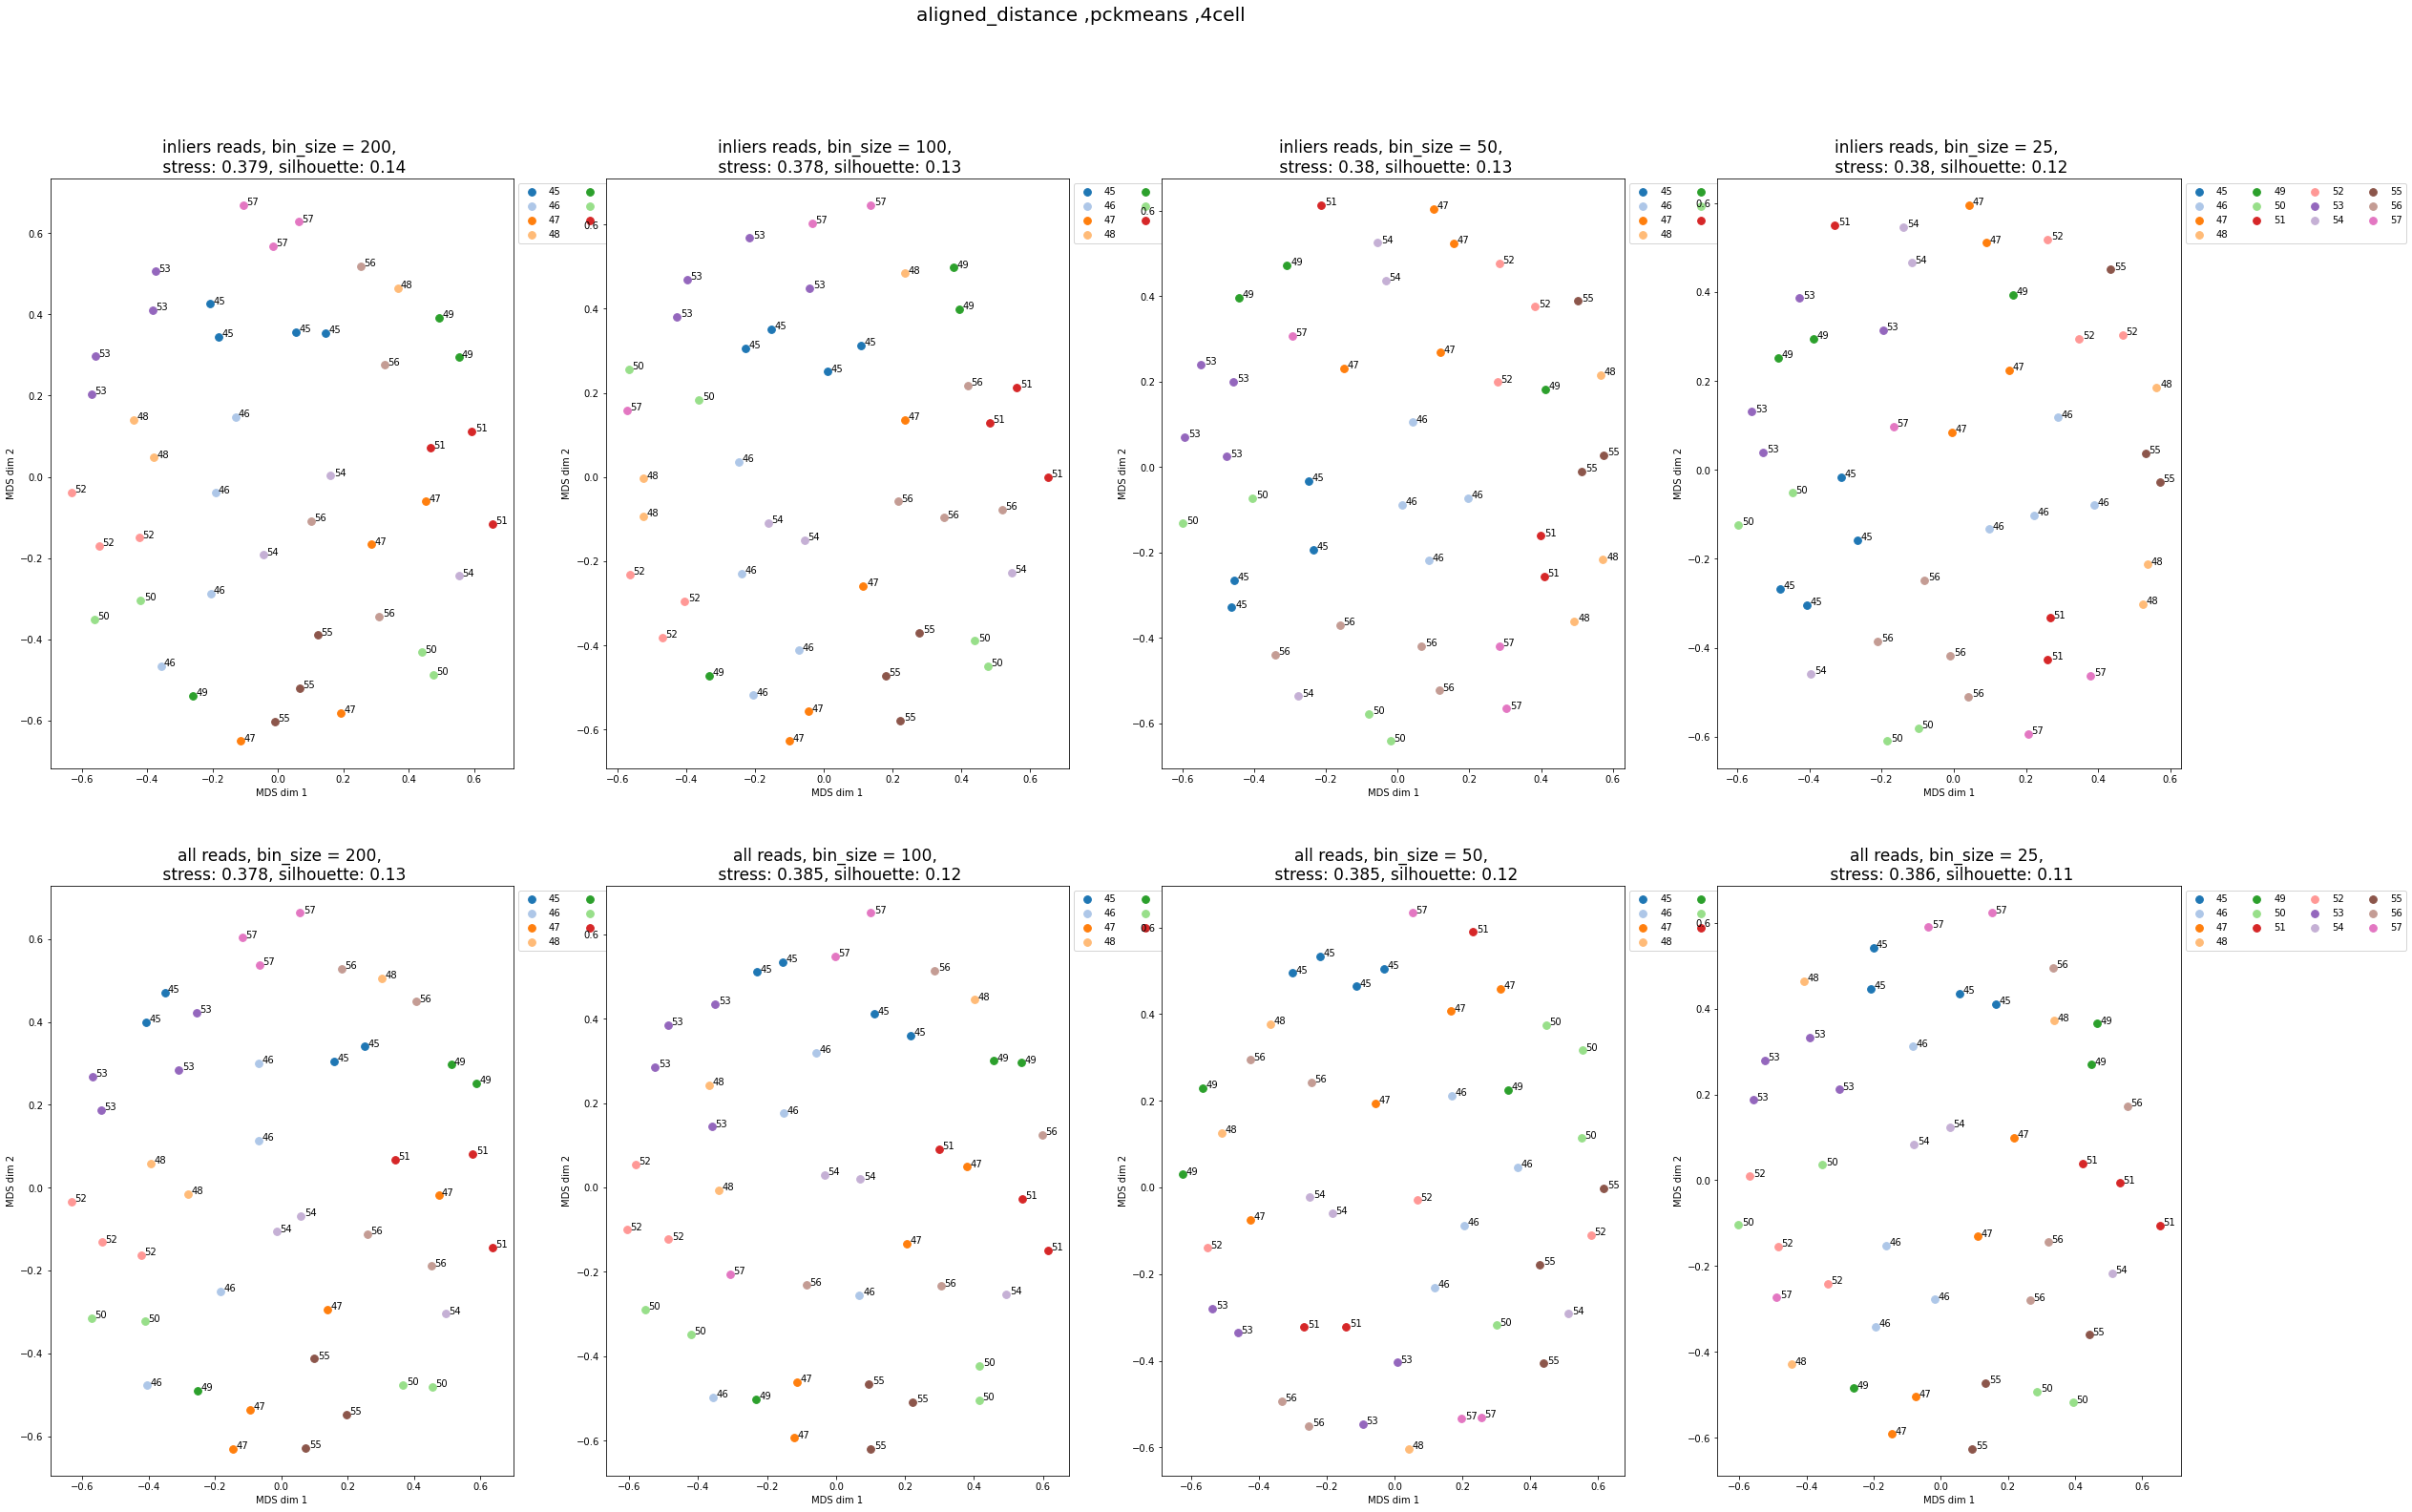

In [14]:
clustering_method = "pckmeans"
stage = "4cell"

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 25))
for row, reads_to_include in enumerate(["inliers", "all"]):
    for col, bin_size in enumerate([200, 100, 50, 25]):
    
        
        dist = np.load("data/inter_cell_aligned_dist_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp.npy".format(19, clustering_method, reads_to_include, bin_size))
        dist[np.where(np.isnan(dist))] = 0 
        dist = dist+dist.T
        
        data = read_data(clustering_method, reads_to_include)
        _4cell_df = data.loc[data.stage == stage]
        embryos = np.sort(_4cell_df.embryo_id.unique())
        vals = np.arange(0,len(embryos))
        embryo_color_dict = dict(zip(embryos, vals))
        color_list = plt.cm.tab20(vals)

        #subsetting the distance matrix to only include the 4cell embryos
        cell_ids = _4cell_df.cell_index.unique()
        dist_id = [cell_id_to_id[i] for i in cell_ids] #indices used to index into the large 109x019 distance matrix
        _4cell_dist = dist[np.ix_(dist_id,dist_id)]
        cell_id_to_4_cell_dist_id = {} #used to index into the smaller (45x45) 4_cell dist matrix array
        for i, cell_id in enumerate(cell_ids):
            cell_id_to_4_cell_dist_id[cell_id] = i

        
        silhouette = silhouette_score(_4cell_dist, metric = "precomputed", labels = np.array(_4cell_df.groupby('cell_index').mean()['embryo_id']))
        print("silhouette before MDS: ", silhouette)
        
        mds = MDS(dissimilarity='precomputed', random_state=0, n_components = 2)
        mds_cells = mds.fit_transform(_4cell_dist) #shape: 109 x 2
        
        
#         silhouette = silhouette_score(mds_cells, labels = np.array(_4cell_df.groupby('cell_index').mean()['embryo_id']))
    
        cmap=plt.get_cmap('tab20')
        for embryo in embryos:
            cell_indeces = data.loc[data.embryo_id==embryo,'cell_index'].unique()
            indeces = [cell_id_to_4_cell_dist_id[cell_id] for cell_id in cell_indeces]
            color = color_list[embryo_color_dict[embryo]]
            axes[row,col].scatter(mds_cells[indeces,0], mds_cells[indeces,1], s = 60, color = color, cmap = cmap, marker = "o",  label= embryo)
            for ind in indeces:
                axes[row,col].text(mds_cells[ind,0]+0.01, mds_cells[ind,1], str(embryo))
        lgd = axes[row,col].legend(ncol = 4, fontsize=10, bbox_to_anchor = (1,1))
        axes[row,col].set_xlabel("MDS dim 1")
        axes[row,col].set_ylabel("MDS dim 2")
        axes[row,col].set_title("{} reads, bin_size = {}, \n stress: {}, silhouette: {}".format(reads_to_include, bin_size, stress(dist, mds_cells), np.round(silhouette,2)), fontsize = 17)
plt.suptitle("aligned_distance" + " ," + clustering_method + " ," + stage, fontsize = 20)
plt.savefig("figures/mds_4cell_aligned_{}.png".format(stage))

<AxesSubplot:>

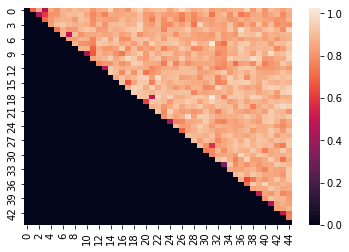

In [20]:
dist = np.load("data/inter_cell_aligned_dist_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp.npy".format(19, clustering_method, reads_to_include,200))
dist[np.where(np.isnan(dist))] = 0 
# dist = dist_4cell+dist_4cell.T
sns.heatmap(dist)

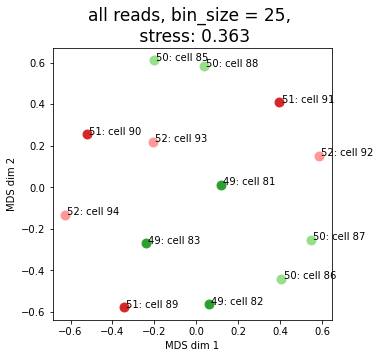

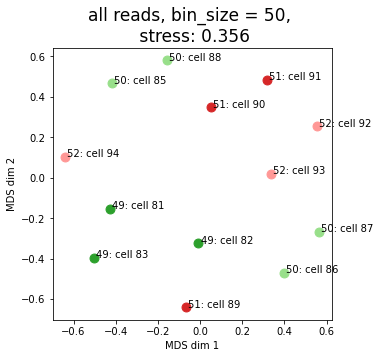

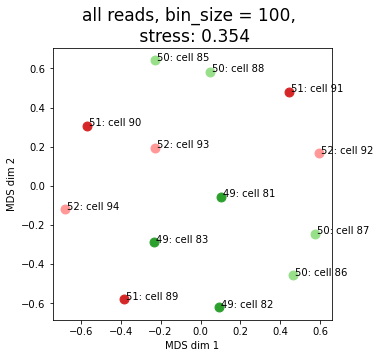

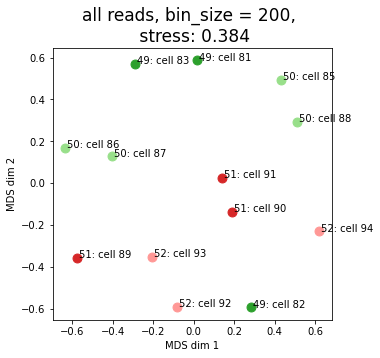

In [69]:
for bin_size in [25,50,100,200]:
    embryos_of_interest = [49,50,51,52]

    reads_to_include = "all"
    stage = "4cell"


    ids_of_interest = [cell_id_to_id[cid] for cid in data.loc[data.embryo_id.isin(embryos_of_interest)].cell_index.unique()]

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

    dist = np.load("data/inter_cell_aligned_dist_4cells_{}chrs_{}_clusters_{}_bin_size_{}Mbp.npy".format(19, clustering_method, reads_to_include, bin_size))
    dist[np.where(np.isnan(dist))] = 0 
    dist = dist+dist.T

    data = read_data(clustering_method, reads_to_include)
    _4cell_df = data.loc[data.stage == stage]
    embryos = np.sort(_4cell_df.embryo_id.unique())
    vals = np.arange(0,len(embryos))
    embryo_color_dict = dict(zip(embryos, vals))
    color_list = plt.cm.tab20(vals)



    #subsetting the distance matrix to only include the 4cell embryos
    # cell_ids = _4cell_df.cell_index.unique()
    # dist_id = [cell_id_to_id[i] for i in cell_ids] #indices used to index into the large 109x019 distance matrix
    _4cell_dist = dist[np.ix_(ids_of_interest,ids_of_interest)]
    id_to_mds_id = {} #used to index into the mds object
    for i, id_ in enumerate(ids_of_interest):
        id_to_mds_id[id_] = i

    # silhouette = silhouette_score(_4cell_dist, metric = "precomputed", labels = np.array(_4cell_df.groupby('cell_index').mean()['embryo_id']))
    # print("silhouette before MDS: ", silhouette)

    mds = MDS(dissimilarity='precomputed', random_state=0, n_components = 2)
    mds_cells = mds.fit_transform(_4cell_dist) #shape: n x 2



    cmap=plt.get_cmap('tab20')
    for embryo in embryos_of_interest:
        cell_indeces = data.loc[data.embryo_id==embryo,'cell_index'].unique()
        indeces = [id_to_mds_id[cell_id_to_id[cell_id]] for cell_id in cell_indeces]
        color = color_list[embryo_color_dict[embryo]]
        axes.scatter(mds_cells[indeces,0], mds_cells[indeces,1], s = 80, color = color, cmap = cmap, marker = "o",  label= embryo)
        for i, ind in enumerate(indeces):
            axes.text(mds_cells[ind,0]+0.01, mds_cells[ind,1], str(embryo) + ": cell " + str(cell_indeces[i]))
    # lgd = axes.legend(ncol = 4, fontsize=10, bbox_to_anchor = (1,1))
    axes.set_xlabel("MDS dim 1")
    axes.set_ylabel("MDS dim 2")
    axes.set_title("{} reads, bin_size = {}, \n stress: {}".format(reads_to_include, bin_size, stress(dist, mds_cells)), fontsize = 17)
    plt.show()